
Install all packages for the tutorial.

In [1]:
!pip install scanpy umap-learn anndata numpy scipy pandas matplotlib scrublet seaborn python-igraph louvain leidenalg

Load all required packages.

In [2]:
import scanpy as sc
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

#pretty plotting
import seaborn as sb



In [3]:
##Adjust figure size: Rescales all plots to a uniform size of 8x8 inches for consistent visualization
plt.rcParams['figure.figsize']=(5,5) #rescale figures
#Set verbosity level: Enables detailed logging for debugging and tracking operations in scanpy workflows
sc.settings.verbosity = 3
#Enhance figure resolution: Improves display and save quality of plots with high DPI settings for better clarity in publications
sc.set_figure_params(dpi=100, dpi_save=100)

In [4]:
#Set Seaborn context for presentation: Adjusts plot aesthetics to make them more legible in large-format visualizations like posters
#sb.set_context(context='poster')


# Read data

When you run the command adata = sc.datasets.pbmc3k(), it loads the PBMC3k dataset as an AnnData object. AnnData is short for "Annotated Data" and is a highly efficient, scalable structure designed to store single-cell omics data. It is widely used in the Scanpy ecosystem and similar tools.

**The AnnData object contains multiple components, and here’s a breakdown:**

---
1. Main Matrix (adata.X)
Contains the data matrix where rows are cells and columns are features (e.g., genes in transcriptomics data).
Each value typically represents normalized gene expression (or raw counts, depending on the dataset).
2. Observations (adata.obs)
Stores metadata about each cell (rows in the matrix). Examples:
Cell type annotations
Experimental batch
Quality control metrics like mitochondrial content.
3. Variables (adata.var)
Contains metadata about each feature (columns in the matrix). Examples:
Gene names
Gene-specific quality metrics.
4. Unstructured Data (adata.uns)
Stores additional information, such as:
Plot settings (e.g., color schemes).
Results of analyses (e.g., clustering or UMAP embeddings).
5. Embeddings (adata.obsm)
Holds reduced-dimensional representations of the data.
Examples: UMAP, PCA, or t-SNE coordinates.
6. Raw Data (adata.raw)
Stores the raw, untransformed data if preprocessing has been applied (optional).
Why Use AnnData?
Efficient Storage: Can handle datasets with tens of thousands of cells and genes efficiently.
Integrated Analysis: Combines metadata, results, and raw data into a single object for seamless analysis.
Extensibility: Compatible with visualization and downstream analyses in tools like Seurat, Muon, or other Scanpy extensions.

In [5]:
# load a preprocessed dataset included with the Scanpy library.
adata = sc.datasets.pbmc3k()

Let us check the dataset size.

In [6]:
adata.shape

(2700, 32738)

In [7]:
##Prints the number of cells (observations) in the dataset loaded into the AnnData object for an initial overview of the data structure.
print('Total number of observations: {:d}'.format(adata.n_obs))

Total number of observations: 2700


# Pre-processing and visualization

## Quality control

**Data quality control can be split into cell QC and gene QC. Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell. It should be noted that high mitochondrial RNA fractions can also be biological signals indicating elevated respiration.**

`Scanpy` provides the `calculate_qc_metrics` function, which computes the following QC metrics:
On the cell level (`.obs` level):
* `n_genes_by_counts`: Number of genes with positive counts in a cell
* `log1p_n_genes_by_counts`: Log(n+1) transformed number of genes with positive counts in a cell
* `total_counts`: Total number of counts for a cell
* `log1p_total_counts`: Log(n+1) transformed total number of counts for a cell
* `pct_counts_in_top_50_genes`: Cumulative percentage of counts for 50 most expressed genes in a cell
* `pct_counts_in_top_100_genes`: Cumulative percentage of counts for 100 most expressed genes in a cell
* `pct_counts_in_top_200_genes`: Cumulative percentage of counts for 200 most expressed genes in a cell
* `pct_counts_in_top_500_genes`: Cumulative percentage of counts for 500 most expressed genes in a cell

On the gene level (`.var` level):
* `n_cells_by_counts`: Number of cells this expression is measured in
* `mean_counts`: Mean expression over all cells
* `log1p_mean_counts`: Log(n+1) transformed mean expression over all cells
* `pct_dropout_by_counts`: Percentage of cells this feature does not appear in
* `total_counts`: Sum of counts for a gene
* `log1p_total_counts`: Log(n+1) transformed sum of counts for a gene

In [8]:
##computes the QC metrics
#Parameters:
#adata: The AnnData object containing the data matrix.
#inplace=True: Adds the computed metrics directly into the obs (for cells) and var (for genes) annotations within the AnnData object.
# sc.pp.calculate_qc_metrics(adata, inplace=True)
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

In [9]:
adata.var
adata.obs
# plt.hist(adata.var.n_cells_by_counts, bins=100, edgecolor='black')

n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
index                                                                        
AAACATACAACCAC-1                781                 6.661855        2421.0   
AAACATTGAGCTAC-1               1352                 7.210080        4903.0   
AAACATTGATCAGC-1               1131                 7.031741        3149.0   
AAACCGTGCTTCCG-1                960                 6.867974        2639.0   
AAACCGTGTATGCG-1                522                 6.259581         981.0   
...                             ...                      ...           ...   
TTTCGAACTCTCAT-1               1155                 7.052721        3461.0   
TTTCTACTGAGGCA-1               1227                 7.113142        3447.0   
TTTCTACTTCCTCG-1                622                 6.434547        1684.0   
TTTGCATGAGAGGC-1                454                 6.120297        1024.0   
TTTGCATGCCTCAC-1                724                 6.586172        1985.0   

                  log1p_total_counts  pct_counts_in_top_50_genes  \
index                                                              
AAACATACAACCAC-1            7.792349                   47.748864   
AAACATTGAGCTAC-1            8.497807                   45.502753   
AAACATTGATCAGC-1            8.055158                   41.314703   
AAACCGTGCTTCCG-1            7.878534                   39.029936   
AAACCGTGTATGCG-1            6.889591                   44.852192   
...                              ...                         ...   
TTTCGAACTCTCAT-1            8.149602                   39.237215   
TTTCTACTGAGGCA-1            8.145550                   37.278793   
TTTCTACTTCCTCG-1            7.429521                   45.783848   
TTTGCATGAGAGGC-1            6.932448                   48.046875   
TTTGCATGCCTCAC-1            7.593878                   46.549118   

                  pct_counts_in_top_100_genes  pct_counts_in_top_200_genes  \
index                                                                        
AAACATACAACCAC-1                    63.279637                    74.969021   
AAACATTGAGCTAC-1                    61.023863                    71.813176   
AAACATTGATCAGC-1                    53.794856                    65.449349   
AAACCGTGCTTCCG-1                    52.898825                    66.691929   
AAACCGTGTATGCG-1                    55.657492                    67.176351   
...                                       ...                          ...   
TTTCGAACTCTCAT-1                    52.528171                    65.761341   
TTTCTACTGAGGCA-1                    51.900203                    63.881636   
TTTCTACTTCCTCG-1                    61.638955                    74.940618   
TTTGCATGAGAGGC-1                    62.402344                    75.195312   
TTTGCATGCCTCAC-1                    61.964736                    73.602015   

                  pct_counts_in_top_500_genes  total_counts_mt  \
index                                                            
AAACATACAACCAC-1                    88.393226             73.0   
AAACATTGAGCTAC-1                    82.622884            186.0   
AAACATTGATCAGC-1                    79.961893             28.0   
AAACCGTGCTTCCG-1                    82.569155             46.0   
AAACCGTGTATGCG-1                    97.757390             12.0   
...                                       ...              ...   
TTTCGAACTCTCAT-1                    81.074834             73.0   
TTTCTACTGAGGCA-1                    78.909196             32.0   
TTTCTACTTCCTCG-1                    92.755344             37.0   
TTTGCATGAGAGGC-1                   100.000000             21.0   
TTTGCATGCCTCAC-1                    88.715365             16.0   

                  log1p_total_counts_mt  pct_counts_mt  total_counts_ribo  \
index                                                                       
AAACATACAACCAC-1               4.304065       3.015283             1057.0   
AAACATTGAGCTA

**Lastly, let us compute the fraction of mitochondrial reads.**
**Note**: mitochondrial genes in human start with 'MT-' **bold text**
#Code Exlanation
mt_gene_mask = np.flatnonzero([gene.startswith('MT-') for gene in adata.var_names])

Creates a mask to identify mitochondrial genes in the dataset.
adata.var_names: Contains the names of all features (e.g., genes) in the dataset.
gene.startswith('MT-'): Checks if the gene name starts with "MT-", which is a common prefix for mitochondrial genes.
np.flatnonzero([...]): Converts the list of True (mitochondrial gene) and False values into the indices of True entries.
Result: A list of indices corresponding to mitochondrial genes.
adata[:, mt_gene_mask].X



Computes the total expression counts for mitochondrial genes for each cell.
axis=1: Summing is performed along the rows (across all mitochondrial genes for each cell).
.A1: Converts the result to a 1D dense array, as .X is a sparse matrix.
adata.obs['mt_frac']

Adds a new column mt_frac to the cell metadata (adata.obs).
This column stores the fraction of total counts derived from mitochondrial genes for each cell.
np.sum(...)/adata.obs['total_counts']

Divides the mitochondrial gene counts by the total counts per cell (adata.obs['total_counts']) to compute the fraction.

In [10]:
#Creates a mask to identify mitochondrial genes in the dataset. adata.var_names:
#Contains the names of all features (e.g., genes) in the dataset. gene.startswith('MT-'): Checks if the gene name starts with "MT-", which is a common prefix for mitochondrial genes. np.flatnonzero([...]): Converts the list of True (mitochondrial gene) and False values into the indices of True entries. Result: A list of indices corresponding to mitochondrial genes. adata[:, mt_gene_mask].X
mt_gene_mask = np.flatnonzero([gene.startswith('MT-') for gene in adata.var_names])
##Selects the expression matrix for mitochondrial genes onlythen Adds a new column mt_frac to the cell metadata (adata.obs). This column stores the fraction of total counts derived from mitochondrial genes for each cell. np.sum(...)/adata.obs['total_counts']
adata.obs['mt_frac'] = np.sum(adata[:, mt_gene_mask].X, axis=1).A1/adata.obs['total_counts']

In [11]:
adata.obs

n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
index                                                                        
AAACATACAACCAC-1                781                 6.661855        2421.0   
AAACATTGAGCTAC-1               1352                 7.210080        4903.0   
AAACATTGATCAGC-1               1131                 7.031741        3149.0   
AAACCGTGCTTCCG-1                960                 6.867974        2639.0   
AAACCGTGTATGCG-1                522                 6.259581         981.0   
...                             ...                      ...           ...   
TTTCGAACTCTCAT-1               1155                 7.052721        3461.0   
TTTCTACTGAGGCA-1               1227                 7.113142        3447.0   
TTTCTACTTCCTCG-1                622                 6.434547        1684.0   
TTTGCATGAGAGGC-1                454                 6.120297        1024.0   
TTTGCATGCCTCAC-1                724                 6.586172        1985.0   

                  log1p_total_counts  pct_counts_in_top_50_genes  \
index                                                              
AAACATACAACCAC-1            7.792349                   47.748864   
AAACATTGAGCTAC-1            8.497807                   45.502753   
AAACATTGATCAGC-1            8.055158                   41.314703   
AAACCGTGCTTCCG-1            7.878534                   39.029936   
AAACCGTGTATGCG-1            6.889591                   44.852192   
...                              ...                         ...   
TTTCGAACTCTCAT-1            8.149602                   39.237215   
TTTCTACTGAGGCA-1            8.145550                   37.278793   
TTTCTACTTCCTCG-1            7.429521                   45.783848   
TTTGCATGAGAGGC-1            6.932448                   48.046875   
TTTGCATGCCTCAC-1            7.593878                   46.549118   

                  pct_counts_in_top_100_genes  pct_counts_in_top_200_genes  \
index                                                                        
AAACATACAACCAC-1                    63.279637                    74.969021   
AAACATTGAGCTAC-1                    61.023863                    71.813176   
AAACATTGATCAGC-1                    53.794856                    65.449349   
AAACCGTGCTTCCG-1                    52.898825                    66.691929   
AAACCGTGTATGCG-1                    55.657492                    67.176351   
...                                       ...                          ...   
TTTCGAACTCTCAT-1                    52.528171                    65.761341   
TTTCTACTGAGGCA-1                    51.900203                    63.881636   
TTTCTACTTCCTCG-1                    61.638955                    74.940618   
TTTGCATGAGAGGC-1                    62.402344                    75.195312   
TTTGCATGCCTCAC-1                    61.964736                    73.602015   

                  pct_counts_in_top_500_genes  total_counts_mt  \
index                                                            
AAACATACAACCAC-1                    88.393226             73.0   
AAACATTGAGCTAC-1                    82.622884            186.0   
AAACATTGATCAGC-1                    79.961893             28.0   
AAACCGTGCTTCCG-1                    82.569155             46.0   
AAACCGTGTATGCG-1                    97.757390             12.0   
...                                       ...              ...   
TTTCGAACTCTCAT-1                    81.074834             73.0   
TTTCTACTGAGGCA-1                    78.909196             32.0   
TTTCTACTTCCTCG-1                    92.755344             37.0   
TTTGCATGAGAGGC-1                   100.000000             21.0   
TTTGCATGCCTCAC-1                    88.715365             16.0   

                  log1p_total_counts_mt  pct_counts_mt  total_counts_ribo  \
index                                                                       
AAACATACAACCAC-1               4.304065       3.015283             1057.0   
AAACATTGAGCTA

**Let us visualize the number of expressed genes and the number of counts as a scatter plot.**

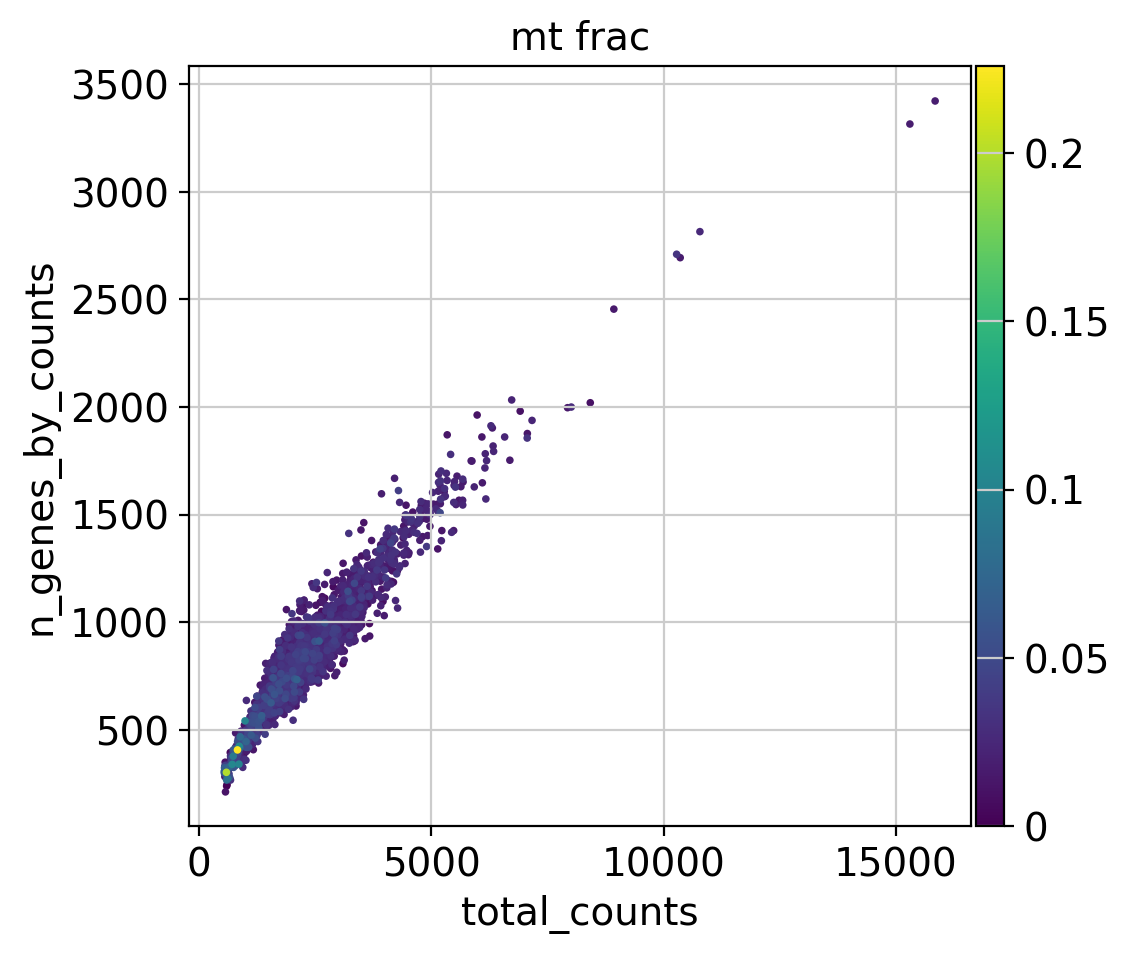

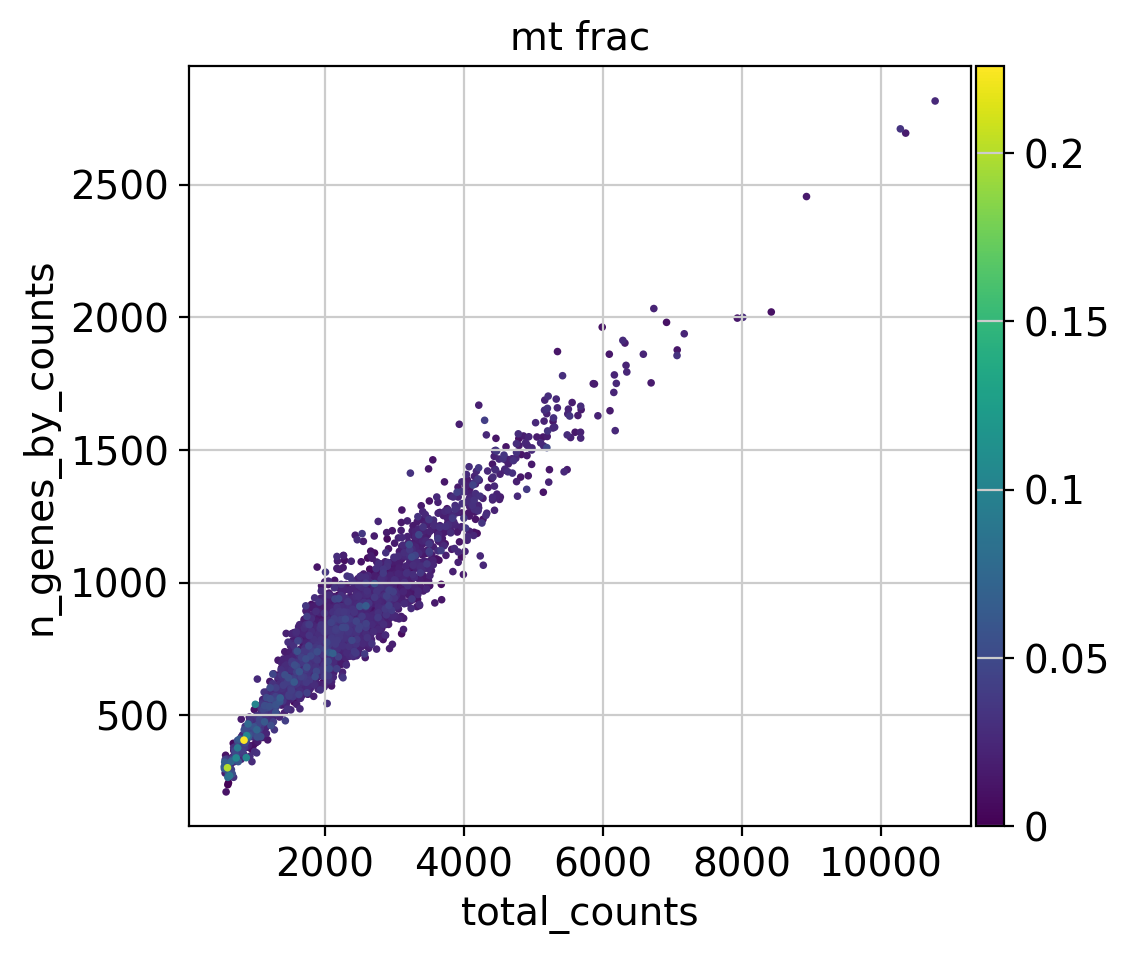

In [12]:
#Data quality summary plots
#Scatter plot of total counts vs. detected genes, colored by mitochondrial fraction, for all cells.
#A focused plot for cells with total counts below 15,000 to examine low-quality data points more closely.
rcParams['figure.figsize']=(5,5)
p1 = sc.pl.scatter(adata, 'total_counts', 'n_genes_by_counts', color='mt_frac', size=30)
p2 = sc.pl.scatter(adata[adata.obs['total_counts']<15000], 'total_counts', 'n_genes_by_counts',
                   color='mt_frac', size=30)

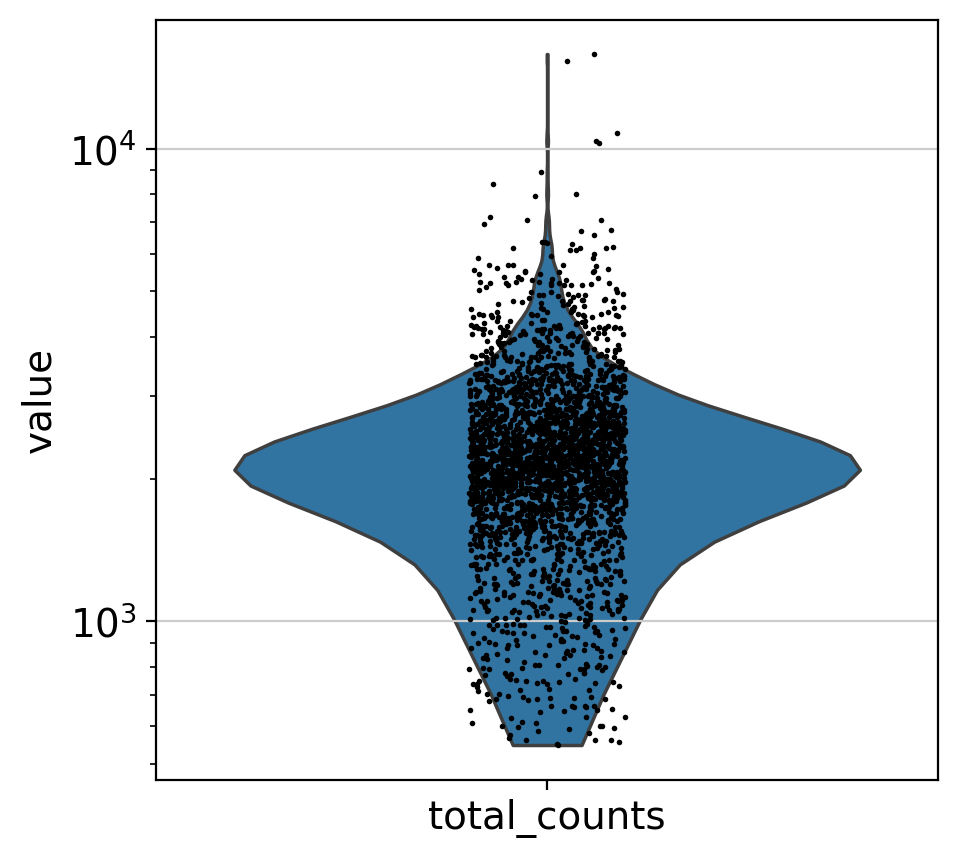

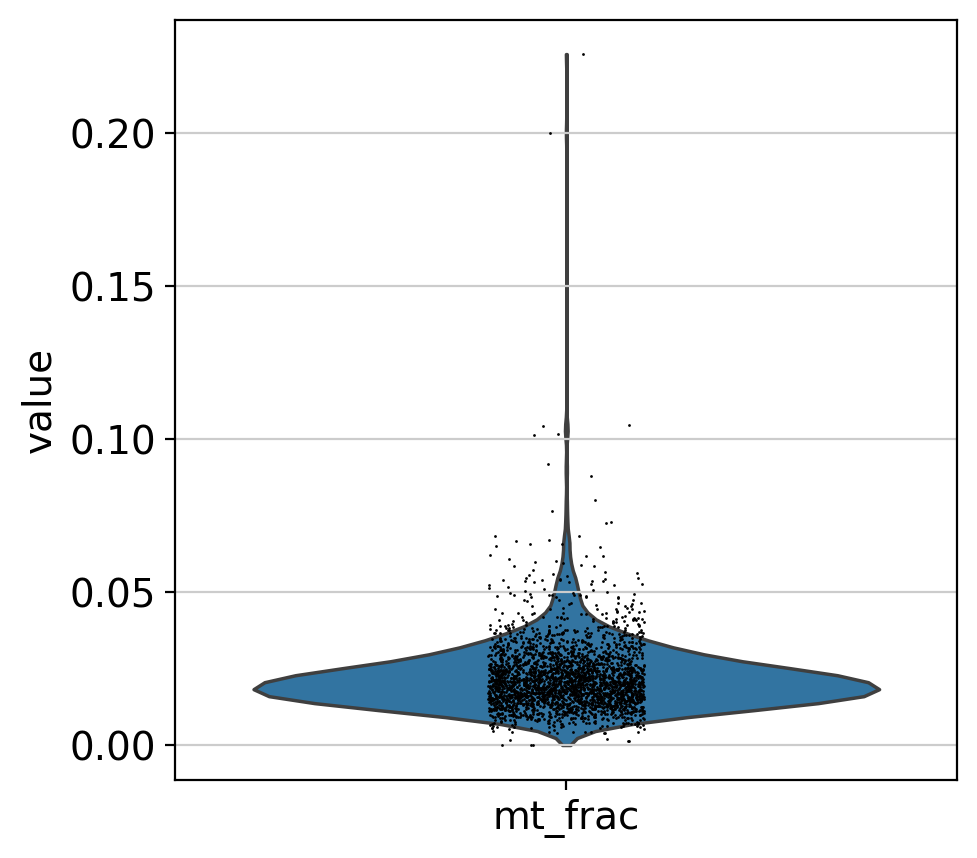

In [13]:
#Sample quality plots
#'total_counts': Specifies the metric to plot, here the total counts (sum of expression values) for each cell.
#groupby='sample': This would group cells by their sample IDs (if provided in adata.obs['sample']) and show separate distributions for each group.
#size=2: Sets the size of the overlayed data points (jittered dots) on the violin plot.
#log=True: Applies a logarithmic transformation to the total_counts for better visualization of skewed distributions.
#cut=0: Restricts the violin plot to the observed data range, without extending beyond it
rcParams['figure.figsize']=(5,5) #set figure size
t1 = sc.pl.violin(adata, 'total_counts',
                  #groupby='sample',
                  size=2, log=True, cut=0)
#'mt_frac': Specifies the mitochondrial fraction per cell as the metric to plot.
t2 = sc.pl.violin(adata, 'mt_frac')

Examine the overall library complexity.
Let us plot the top 20 highest expressed genes first.

normalizing counts per cell
    finished (0:00:00)


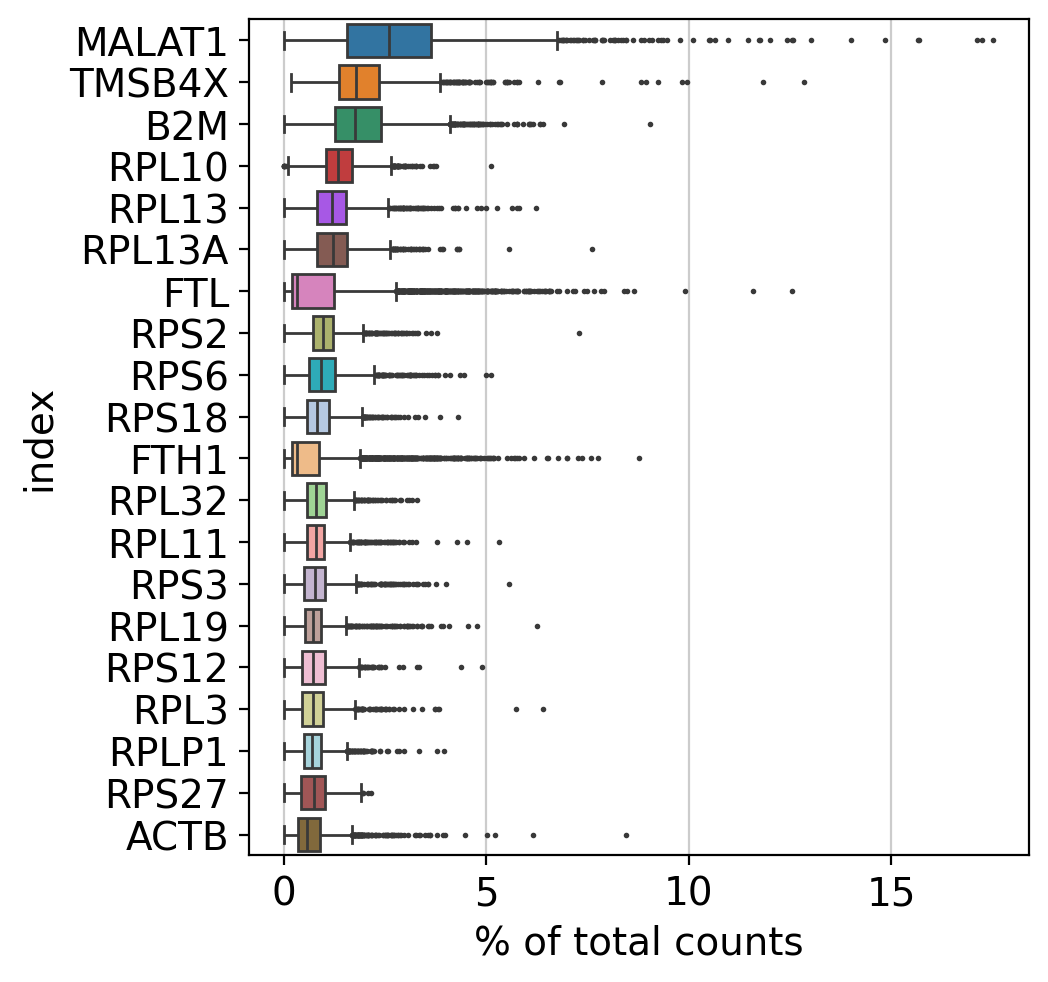

In [14]:
#Creates a bar plot showing the proportion of total expression contributed by the top n_top most highly expressed genes.
#How does it work :
#1. calculates the total expression of each gene across all cells.
#2. Ranks genes by their total expression.

sc.pl.highest_expr_genes(adata, n_top=20)

**How many counts come from the top 50/100/200/500 highest expressed genes? Visualize the fraction as violin plot.**

/usr/local/lib/python3.11/dist-packages/scanpy/plotting/_anndata.py:928: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(


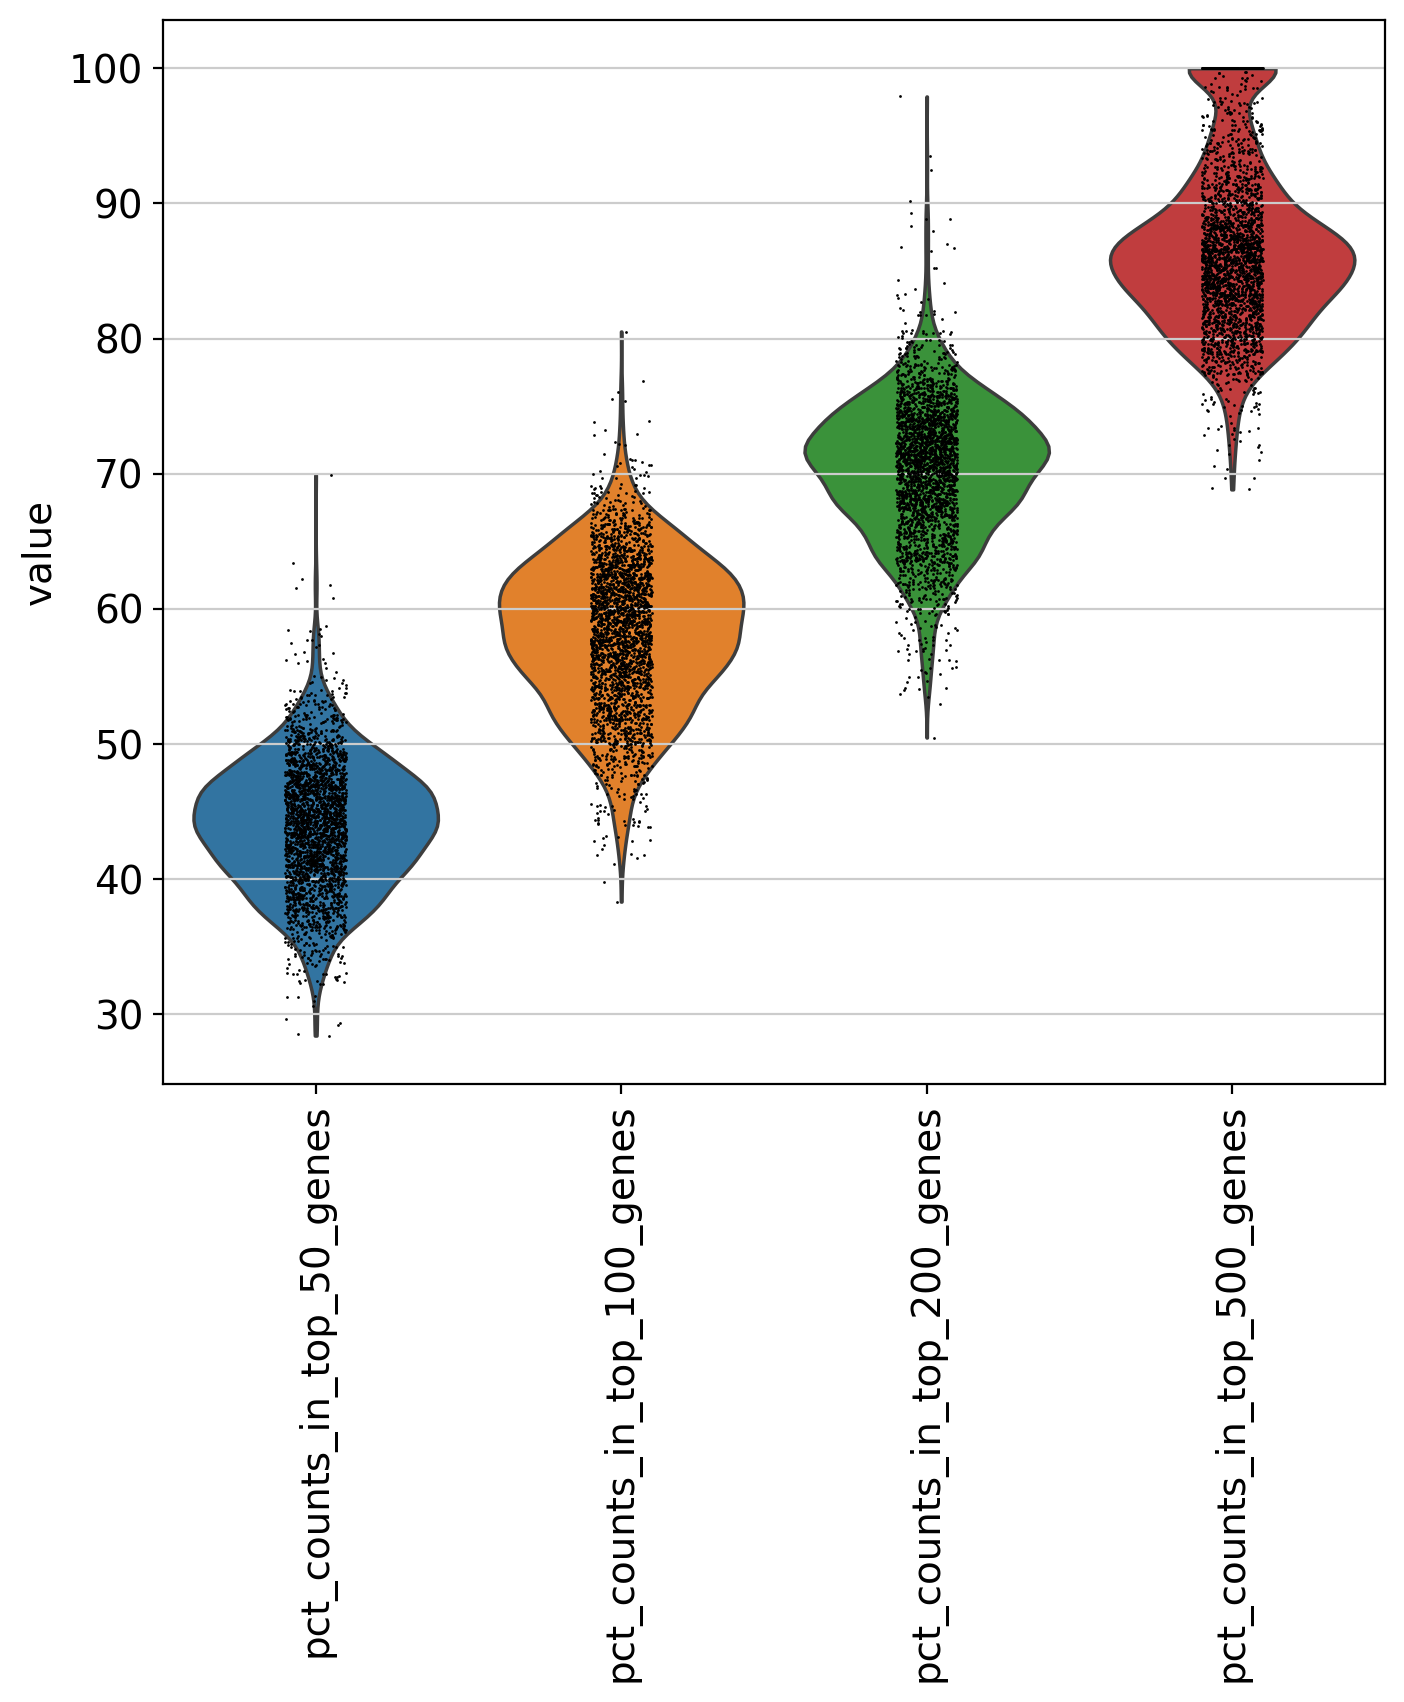

In [15]:
rcParams['figure.figsize']=(7,7) #set figure size
custom_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
t3 = sc.pl.violin(adata, keys=['pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
                     'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
                    ],palette=custom_palette,rotation = 90)

'''**By looking at plots of the number of genes versus the number of counts with MT fraction information, we can assess whether there are cells with unexpected summary statistics. It is important here to look at these statistics jointly.  We should probably still filter out some cells with very few genes as these may be difficult to annotate later. This will be true for the initial cellular density between 1000-4000 counts and < ~500 genes**.'''

**Furthermore it can be seen in the main cloud of data points, that cells with lower counts and genes tend to have a higher fraction of mitochondrial counts. These cells are likely under stress or are dying. When apoptotic cells are sequenced, there is less mRNA to be captured in the nucleus, and therefore fewer counts overall, and thus a higher fraction of counts fall upon mitochondrial RNA. If cells with high mitochondrial activity were found at higher counts/genes per cell, this would indicate biologically relevant mitochondrial activity**

Create a histogram for the total number of counts. Further, create a histogram for the low count and high count regime, each.
Note: `pandas` does some histogram plotting with `adata.obs['n_counts'].hist()`, howecer, you will obtain prettier plots with `histplot` from `seaborn`.  
  

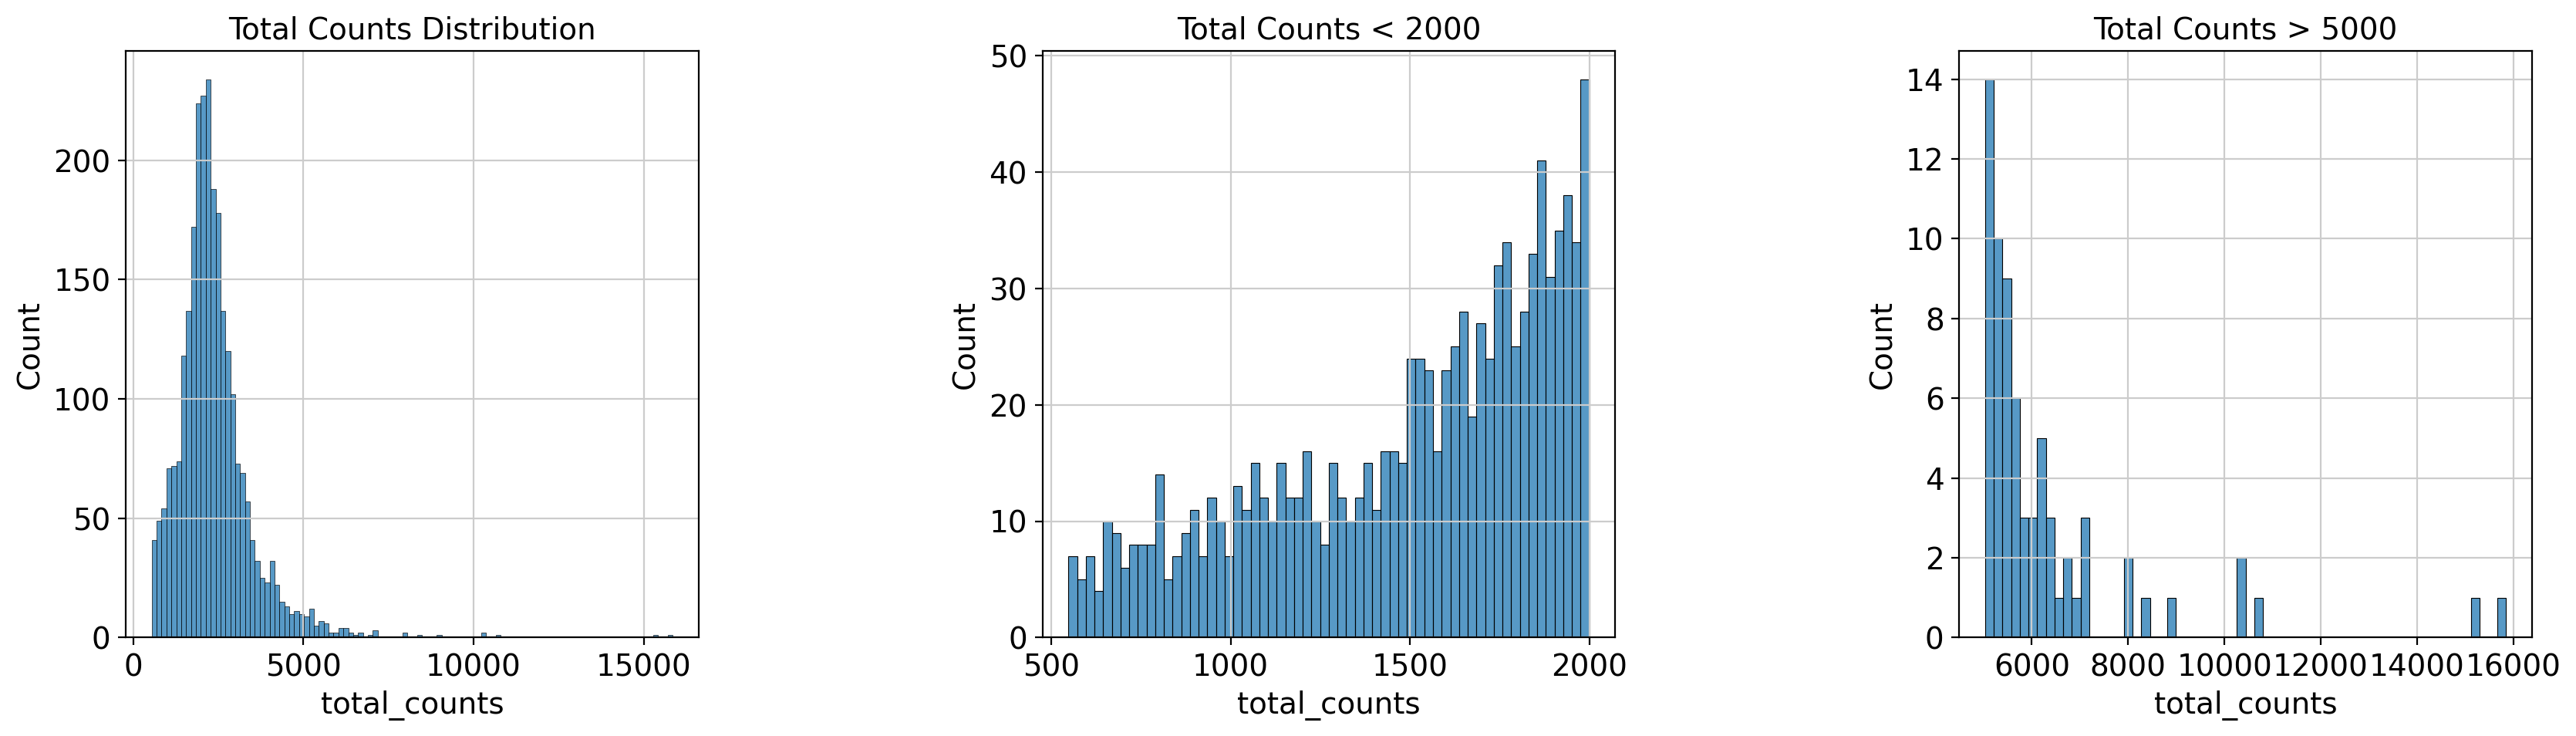

In [16]:
#This code generates histograms to explore the distribution of total counts in single-cell data.
#It provides insights into the overall count distribution and highlights specific subsets of cells with
#total counts below 2000 and above 5000. Such visualizations are useful for identifying thresholds and filtering criteria during preprocessing.
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np

# Set figure size
plt.rcParams['figure.figsize'] = (20, 5)

# Define subplot indices
fig_ind = np.arange(131, 134)

# Create figure
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

# Plot total counts distribution
p3 = sb.histplot(adata.obs['total_counts'],
                 kde=False,
                 ax=fig.add_subplot(fig_ind[0]))
p3.set_title('Total Counts Distribution')

# Plot total counts less than 2000
p4 = sb.histplot(adata.obs['total_counts'][adata.obs['total_counts'] < 2000],
                 kde=False, bins=60,
                 ax=fig.add_subplot(fig_ind[1]))
p4.set_title('Total Counts < 2000')

# Plot total counts greater than 5000
p5 = sb.histplot(adata.obs['total_counts'][adata.obs['total_counts'] > 5000],
                 kde=False, bins=60,
                 ax=fig.add_subplot(fig_ind[2]))
p5.set_title('Total Counts > 5000')

# Show the plots
plt.show()


Histograms of the number of counts per cell show a small group of cells with fewer than 700 counts, which are likely uninformative given the overall distribution of counts. This may be cellular debris found in droplets.

On the upper end of counts, we see a population of cells with high counts with decaying slope at 5,000 counts. We estimate this population to range until 10,000 counts. This estimation is performed by visually tracing a Gaussian around the population.

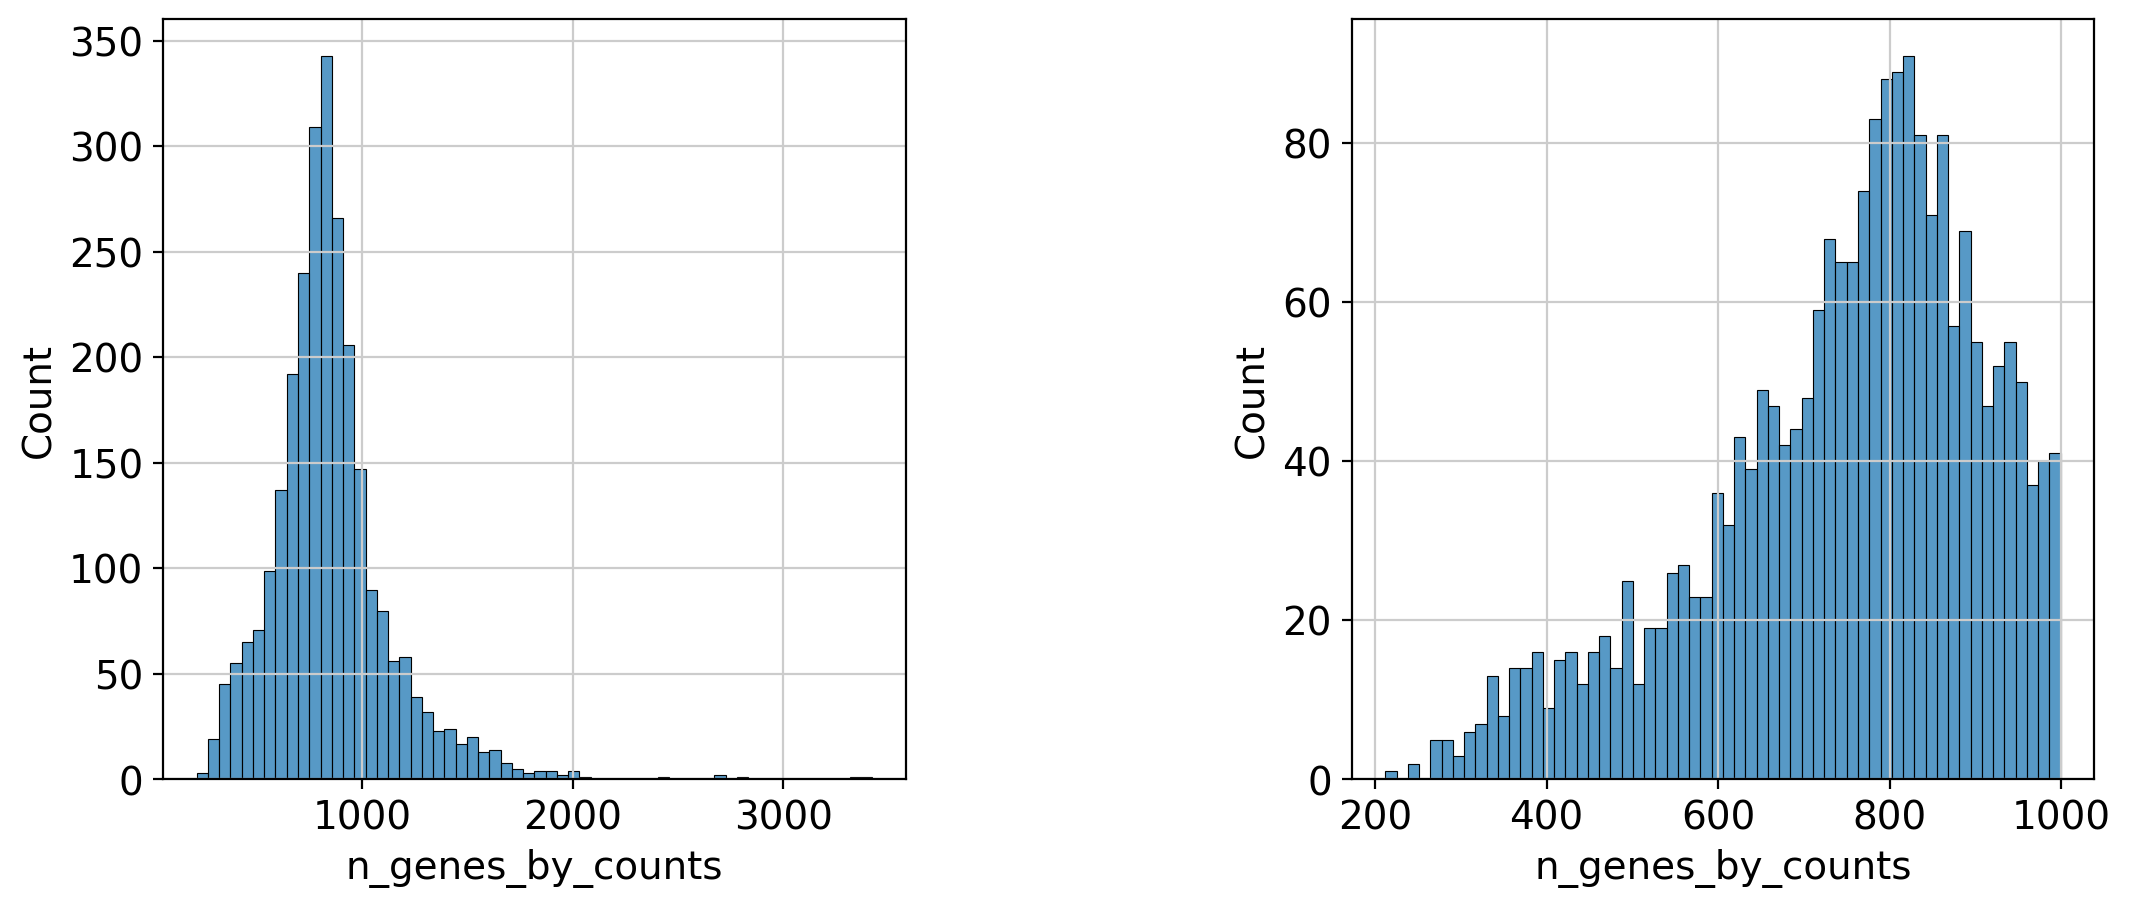

In [17]:
#Create a histogram for the total number of genes. Further, create a histogram for the low gene count and high gene count regime, each.

#Thresholding decision: genes

rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6) #create a grid for subplots

p6 = sb.histplot(adata.obs['n_genes_by_counts'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))
#plot a histogram for cells with less than 1000 detected genes based on the n_genes_by_counts metric :
p7 = sb.histplot(adata.obs['n_genes_by_counts'][adata.obs['n_genes_by_counts']<1000] #Filters cells where the number of detected genes is less than 1000.
                 , kde=False #disables the Kernel Density Estimate, leaving only the histogram
                 , bins=60, ax=fig.add_subplot(fig_ind[1]))
plt.show()

Two populations of cells with low gene counts can be seen in the above plots. Given these plots, and the plot of genes vs counts above, we decide to filter out cells with fewer than 500 genes expressed. Below this we are likely to find dying cells or empty droplets with ambient RNA. Looking above at the joint plots, we see that we filter out the main density of low gene cells with this threshold.

 **In general it is a good idea to be permissive in the early filtering steps, and then come back to filter out more stringently when a clear picture is available of what would be filtered out. This is available after visualization/clustering. For demonstration purposes we stick to a simple (and slightly more stringent) filtering here**

Create a histogram for the fraction of mitochondrial genes. Further, create a histogram for the high fraction regime, each.

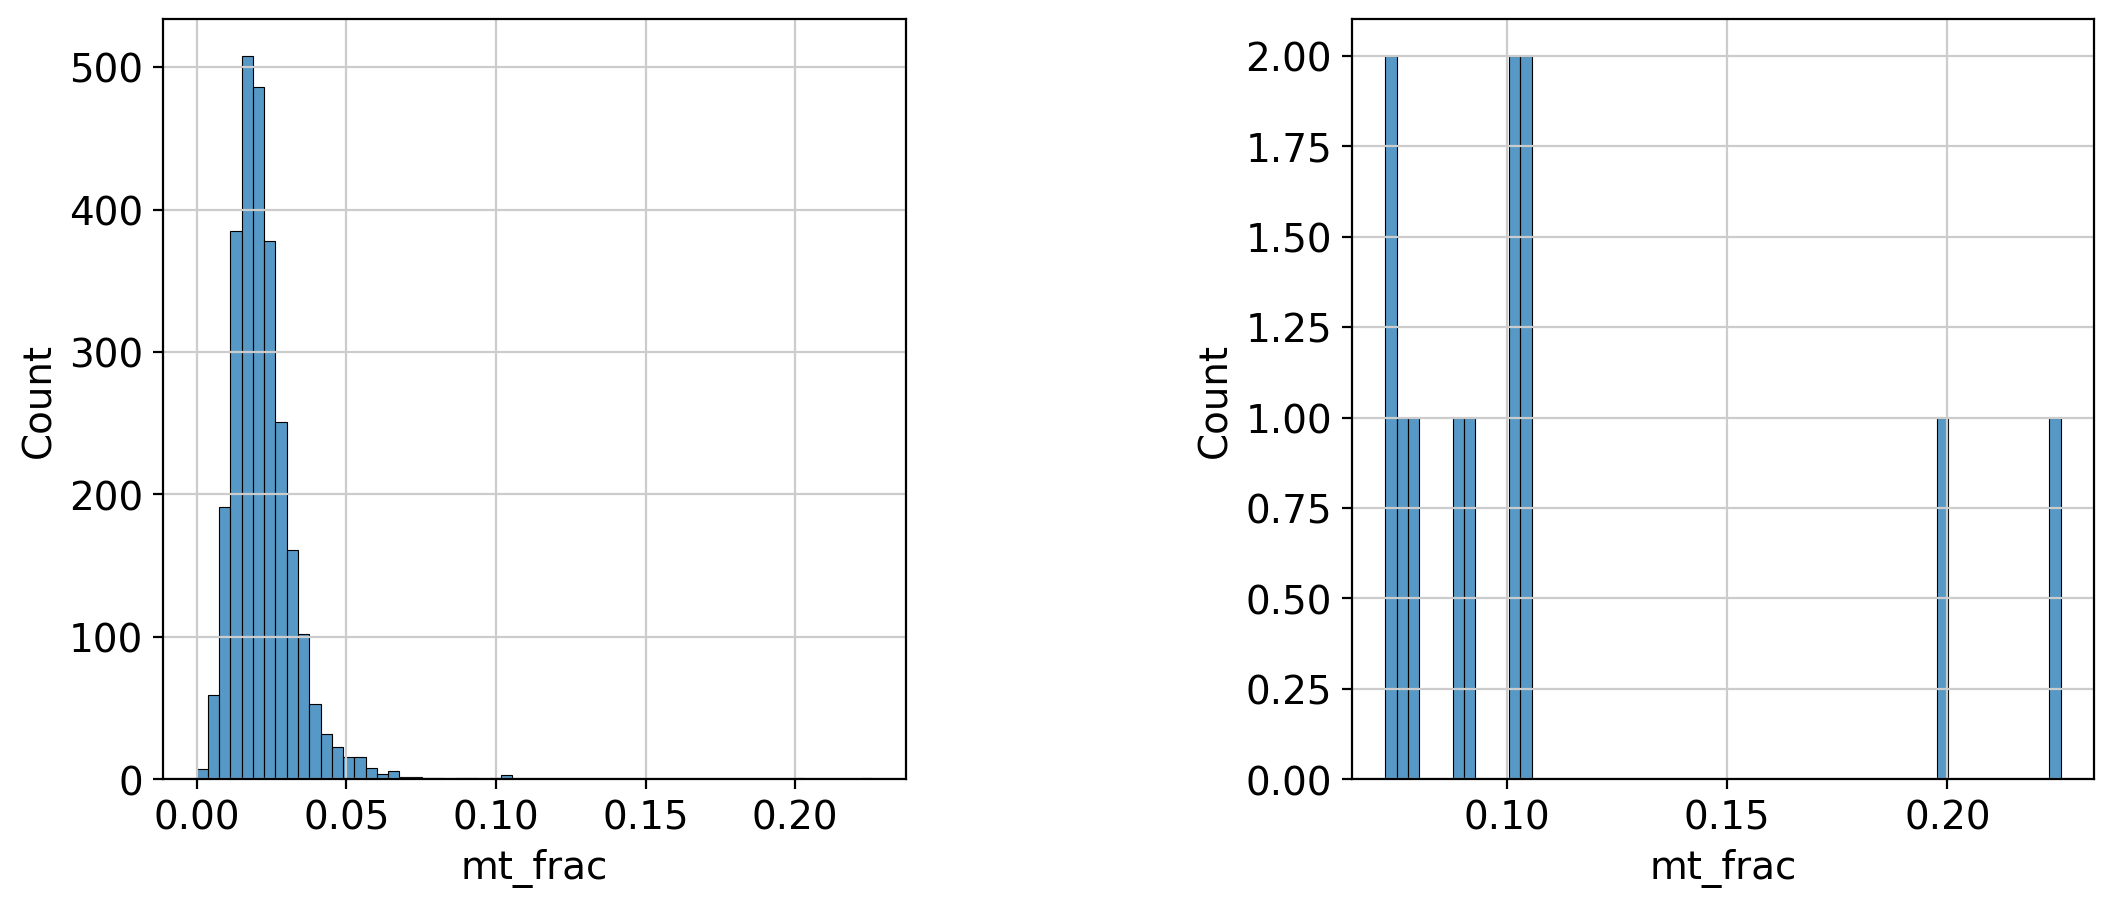

In [18]:
#Thresholding decision: mitochondrial reads

rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p8 = sb.histplot(adata.obs['mt_frac'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p9 = sb.histplot(adata.obs['mt_frac'][adata.obs['mt_frac']>0.07],
                 kde=False, bins=60, ax=fig.add_subplot(fig_ind[1]))
plt.show()

**Filter your cells according for the total number of counts, number of expressed genes and fraction of mitochondrial reads. Check the number of remaining cells after each filtering step.**

In [19]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 700)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 10000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.1]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 200)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 2700
filtered out 43 cells that have less than 700 counts
Number of cells after min count filter: 2657
filtered out 5 cells that have more than 10000 counts
Number of cells after max count filter: 2652
Number of cells after MT filter: 2647
Number of cells after gene filter: 2647


/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_simple.py:168: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


Next, filter out non-expressed genes. Check the number of remaining genes after filtering.

In [20]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=3)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 32738
filtered out 19082 genes that are detected in less than 3 cells
Number of genes after cell filter: 13656


The filtering is performed based on the thresholds we identified from the QC plots. Genes are also filtered if they are not detected in at least 20 cells. This reduces the dimensions of the matrix by removing 0 count genes and genes which are not sufficiently informative of the dataset.

### Summarize sample information

In order to group by `batch` (for future purposes, because we presently deal with one sample), let us add a `batch` covariate to the `adata` object.

In [21]:
adata.obs['batch'] = '1'

df = adata.obs[['n_genes_by_counts','total_counts', 'batch']]
df_all = pd.DataFrame(df.groupby(by='batch')['n_genes_by_counts'].apply(np.mean).values,
                      index=df.groupby(by='batch')['n_genes_by_counts'].apply(np.mean).index,
                      columns=['mean_genes'])

df_all['median_genes']=df.groupby(by='batch')['n_genes_by_counts'].apply(np.median).values
df_all['mean_counts']=df.groupby(by='batch')['total_counts'].apply(np.mean).values
df_all['median_counts']=df.groupby(by='batch')['total_counts'].apply(np.median).values
df_all

mean_genes  median_genes  mean_counts  median_counts
batch                                                      
1      852.443143         820.0   2378.82251         2214.0

## Normalization

So far, our dataset is a count matrix. Here, every count corresponds to an mRNA molecule captured in the scRNA-seq experiment. As not all mRNA molecules in a cell are captured, there is a variability in the total number of counts detected between cells that results from both the number of molecules that were in the cells, and the sampling. As we cannot assume that all cells contain an equal number of molecules (cell sizes can differ substantially), we have to estimate the number of molecules that were initially in the cells. In fact, we don't estimate the exact number of molecules, but instead estimate cell-specific factors that should be proportional to the true number of molecules. These are called size factors. Normalized expression values are calculated by dividing the measured counts by the size factor for the cell.

Several methods for normalization for scRNA-seq data have been proposed. Ideally, we want to apply the `scran` library size normalization followed by log-transformation. However, `scran` is again an R package, and we use the simpler normalisation to logCPM, `i.e.` we divide by the library size followed by the log-transformation. In addition, we save the count matrix to `layers` as 'counts'.

In [22]:
adata.layers['counts'] = adata.X.copy()

We use the logCPM normalisation: Normalise with the library size and log-scale.

In [23]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added
    'n_counts', counts per cell before normalization (adata.obs)


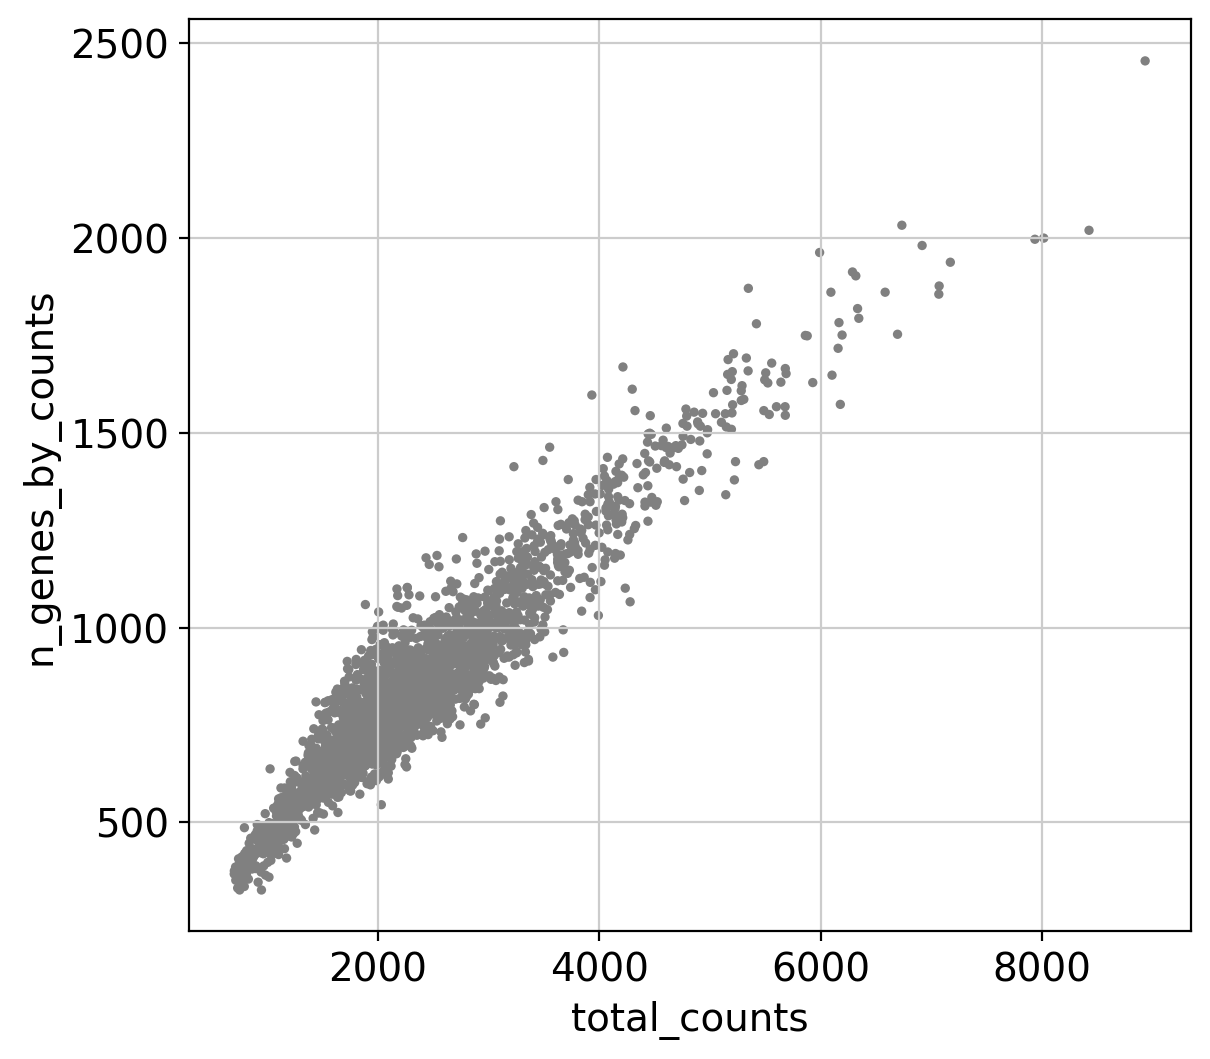

In [24]:
# Visualize the estimated size factors
rcParams['figure.figsize']=(6,6)
sc.pl.scatter(adata,  'total_counts', 'n_genes_by_counts')


## Batch correction - general remarks

This dataset consists of a single batch, thus, batch effect correction is not an issue here. If you handle several batches, you may observe differences across samples, for instance, in the library size per dataset. Such differences may contribute to the batch effect. [Büttner et al., Nat Meth (2019)](https://www.nature.com/articles/s41592-018-0254-1) compared the performance of several batch correction methods. For low-to-medium complexity datasets, ComBat performed best among the tested tools. ComBat is also available in `scanpy` (see `sc.pp.combat`).

For high complexity data, especially when you encounter changes in cell type composition, consider to use a data integration method of your choice. We distinguish three different types, *i.e.* if the methods create a corrected data matrix (in feature space), an embedding or a knn-graph. Examples are:
1. feature space: MNN (`scanpy.external.pp.mnn_correct`), scanorama (integrates with scanpy), Seurat v3 (R based)
2. embedding: scVI (Python based), Harmony (R based), scanorama
3. knn-graph: conos (R based), BBKNN (`scanpy.external.pp.bbknn`)

Several benchmarking studies aimed to determine best performing methods. In simple cases, Seurat v3 and Harmony performed best [Tran et al., Genome Biology (2020)](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1850-9) and [Chazarra-Gil et al., biorxiv (2020)](https://www.biorxiv.org/content/10.1101/2020.05.22.111211v2). More complex scenarios have been benchmarked in [Luecken et al., biorxiv (2020)](https://www.biorxiv.org/content/10.1101/2020.05.22.111161v2), where BBKNN, Scanorama, and scVI performed well. Furthermore, Scanorama had high scores in the preservation of biological signals, while BBKNN tended to overcorrect. Moreover, Luecken et al. tested different pre-processing schemes. In general, **selecting highly variable genes prior to batch correction improved the batch effect correction result**. We continue with the selection of highly variable genes.


## Feature selection (Highly variable genes)

We extract highly variable genes (HVGs) to further reduce the dimensionality of the dataset and include only the most informative genes. Genes that vary substantially across the dataset are informative of the underlying biological variation in the data. As we only want to capture biological variation in these genes, we select highly variable genes after normalization and batch correction. HVGs are used for clustering, trajectory inference, and dimensionality reduction/visualization, while the full data set is used for computing marker genes, differential testing, cell cycle scoring, and visualizing expression values on the data.

Here we use a standard technique for the extraction of highly variable genes from the 10X genomics preprocessing software *CellRanger*. Typically between 1000 and 5000 genes are selected. Here, we extract the top 4000 most variable genes for further processing. If particular genes of importance are known, one could assess how many highly variable genes are necessary to include all, or the majority, of these.

Compute highly variable genes and visualize.

In [25]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=2000)
#Sums up the number of True values in the 'highly_variable' column, which gives the count of highly variable genes.
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 2000


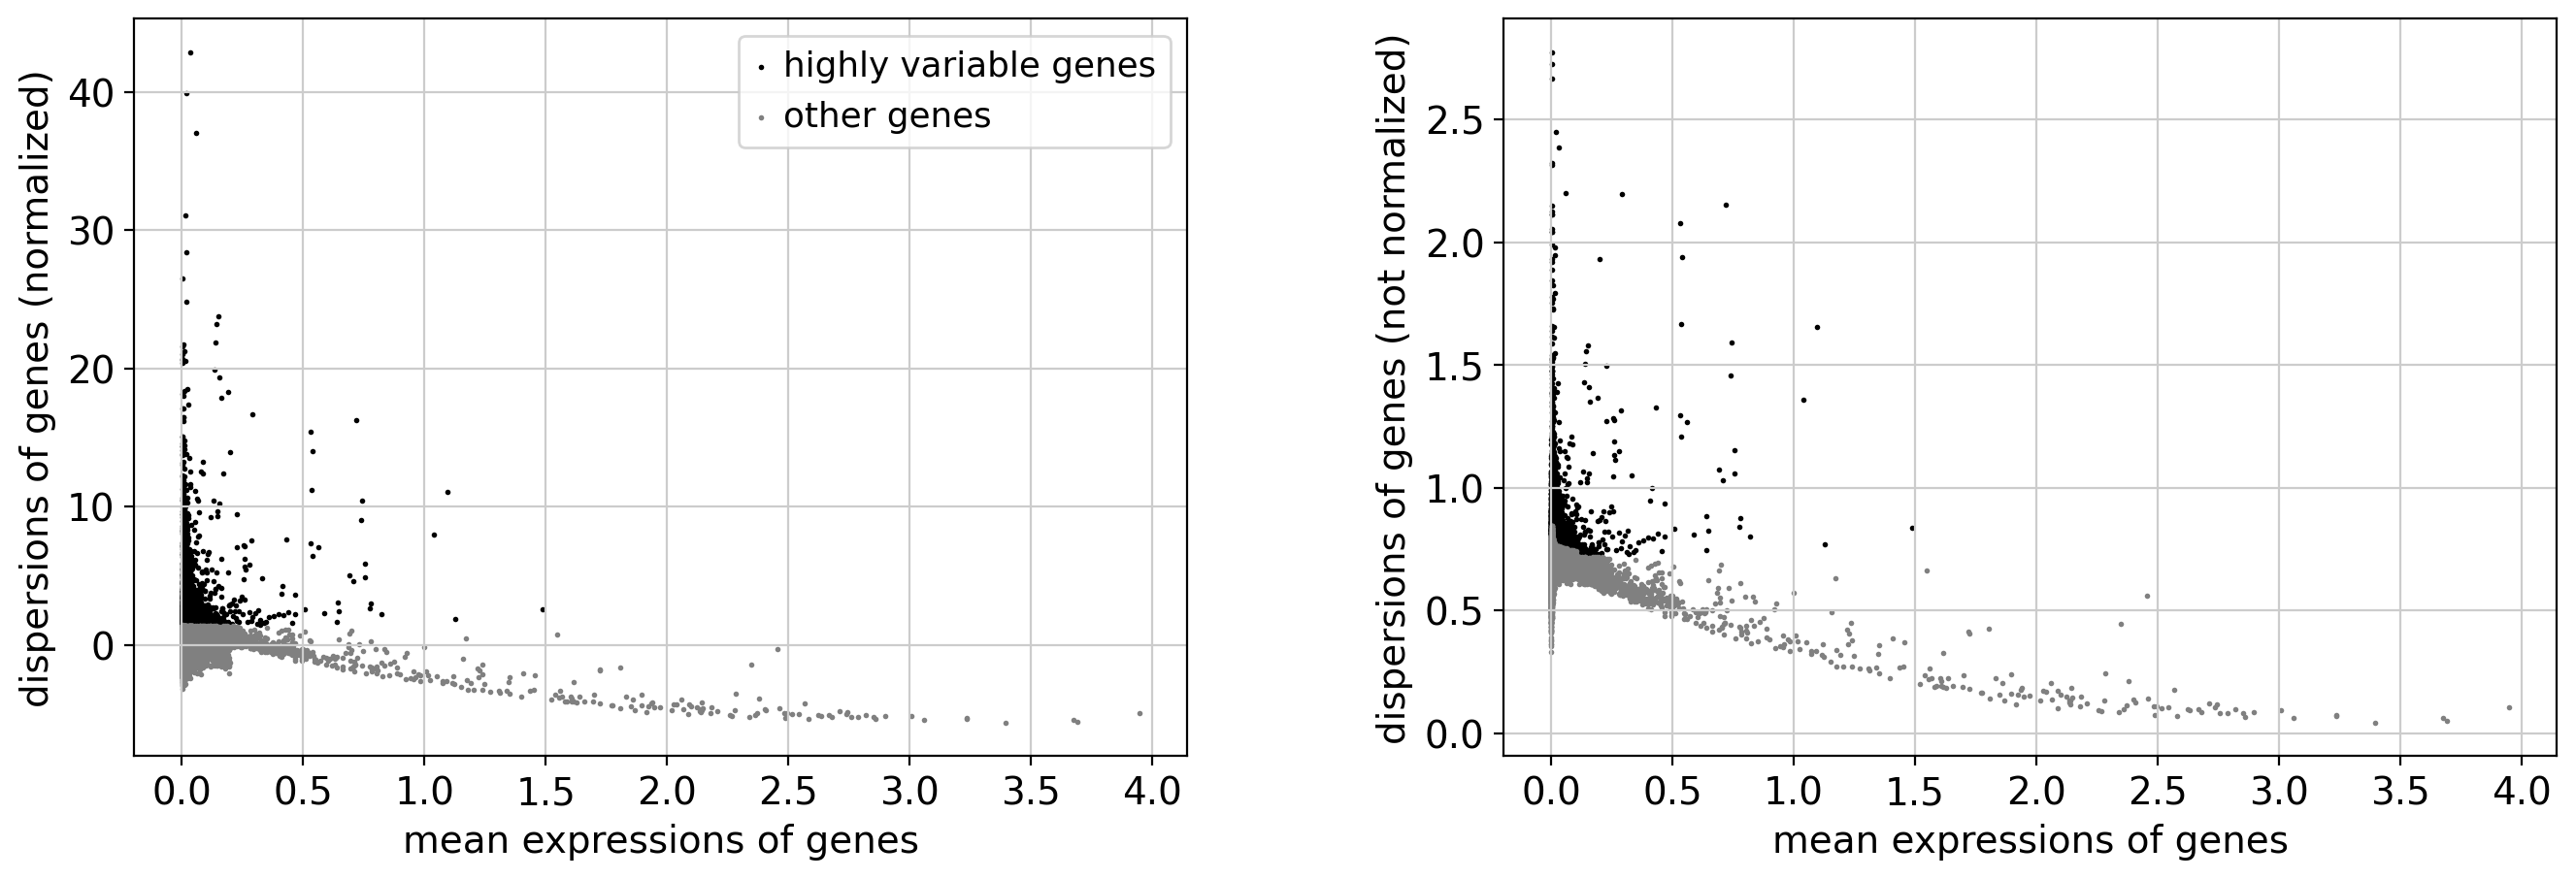

In [26]:
#Each dot represents a gene in the dataset.
#the axes are:
#Mean expression (log-transformed mean of gene counts across cells).
#Variance (log-transformed or normalized).
#Highly Variable Gene:The most variable genes (as determined by the sc.pp.highly_variable_genes function) are highlighted.
rcParams['figure.figsize']=(8,5)
sc.pl.highly_variable_genes(adata)

The plots show how the data was normalized to select highly variable genes irrespective of the mean expression of the genes. This is achieved by using the index of dispersion which divides by mean expression, and subsequently binning the data by mean expression and selecting the most variable genes within each bin.

Highly variable gene information is stored automatically in the `adata.var['highly_variable']` field. The dataset now contains:

* count data as layer 'counts' in adata
* log-CPM normalized data in adata.X
* highly variable gene annotations in `adata.var['highly_variable']`


## Visualization

Visualizing scRNA-seq data is the process of projecting a high-dimensional matrix of cells and genes into a few coordinates such that every cell is meaningfully represented in a two-dimensional graph. However, the visualization of scRNA-seq data is an active area of research and each method defines 'meaningful' in its own way.

Overall t-SNE visualizations have been very popular in the community, however the recent UMAP algorithm has been shown to better represent the topology of the data.

We will look at several visualizations to decide which visualization best represents the aspect of the data.

Compute the following embeddings: PCA, t-SNE, UMAP, diffusion map and force-directed graph. Please compute PCA first and compute nearest neighbors next. All other embeddings rely on this information. Visualize the embeddings and color by the total number of counts.

In [28]:
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')

computing PCA
    with n_comps=50


/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


    finished (0:00:00)


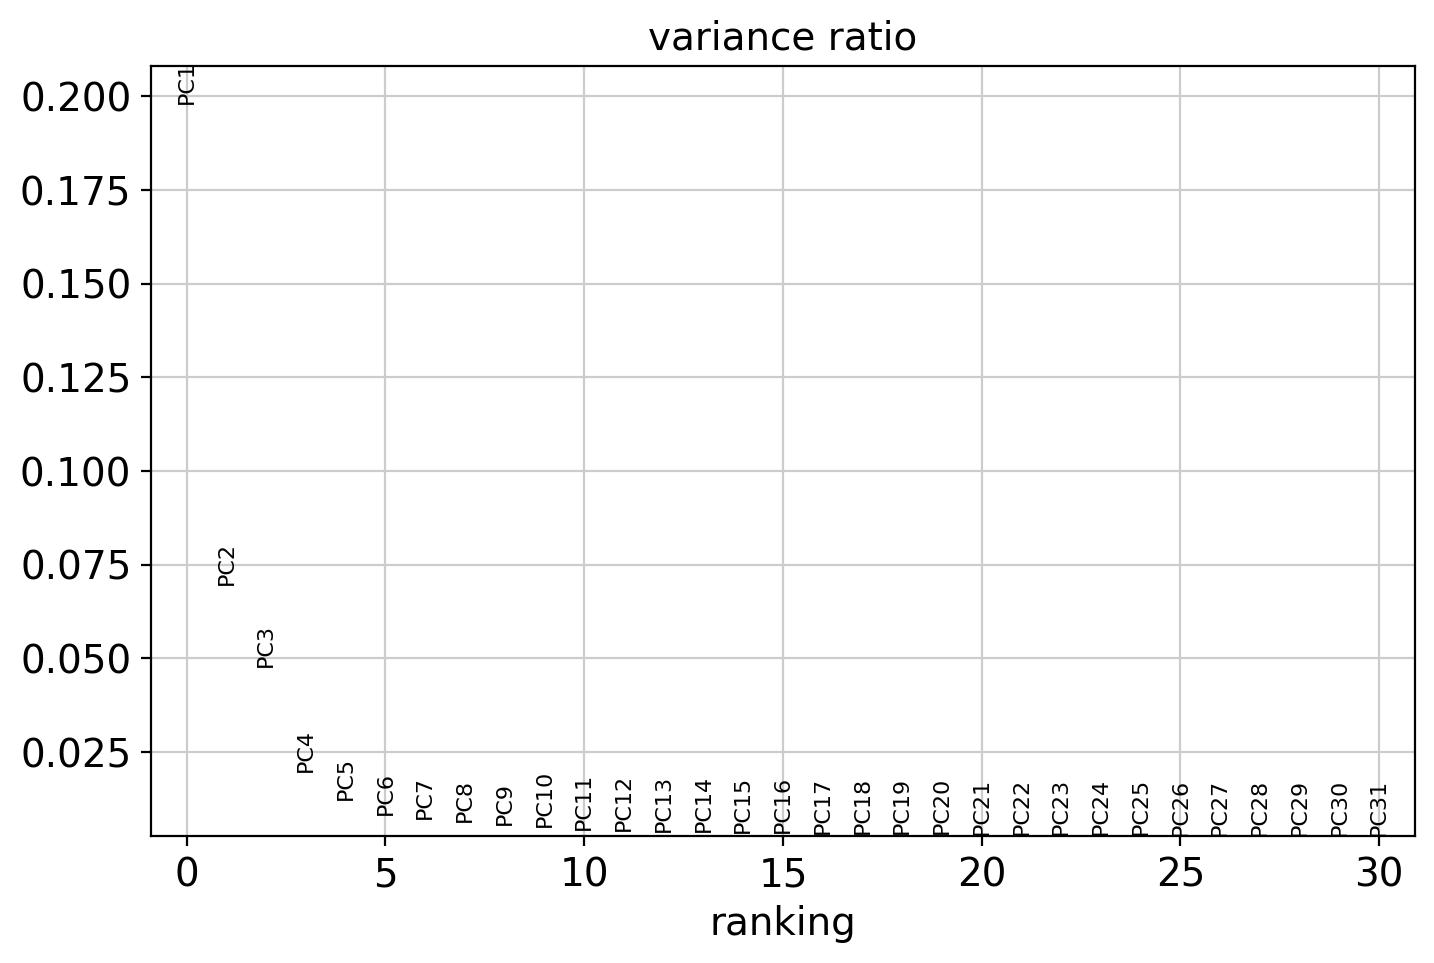

In [29]:
#To determine the number of informative principal components, let us review the variance contribution of each component.
sc.pl.pca_variance_ratio(adata)

Using the elbow method, we select the first 10 PCs as informative.

In [30]:
sc.pp.pca(adata, n_comps=40, use_highly_variable=True, svd_solver='arpack')
# Performs Principal Component Analysis (PCA) on the data.
# - n_comps=10: Retains the top 10 principal components.
# - use_highly_variable=True: Uses only highly variable genes for PCA.
# - svd_solver='arpack': Specifies the solver for faster computation of PCA.

sc.pp.neighbors(adata,n_neighbors=10, n_pcs=40)
# Computes the neighborhood graph of cells.
# - This step is essential for downstream clustering and visualization.
# - It constructs a k-nearest neighbor (kNN) graph in the PCA space.

sc.tl.tsne(adata)
# Computes t-SNE (t-distributed Stochastic Neighbor Embedding) for dimensionality reduction.
# - Note: n_jobs (parallel computation) works only with MulticoreTSNE, not the default implementation.

sc.tl.umap(adata)
# Computes UMAP (Uniform Manifold Approximation and Projection) for dimensionality reduction.
# - UMAP is commonly used for visualizing high-dimensional single-cell data.

sc.tl.diffmap(adata)
# Computes Diffusion Map for dimensionality reduction.
# - Useful for identifying continuous trajectories or transitions between cell states.

sc.tl.draw_graph(adata)
# Computes a force-directed graph layout for visualizing the neighborhood graph.
# - This method provides an alternative to UMAP for visualizing the structure of single-cell data.


computing PCA
    with n_comps=40
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:23)
computing tSNE
    using 'X_pca' with n_pcs = 40
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm)
    'tsne', tSNE parameters (adata.uns) (0:00:17)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:02)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9997185  0.99758095 0.9920782  0.9830468  0.9738395
     0.96905416 0.966909   0.93577766 0.9275316  0.89280885 0.88651896
     0.8793834  0.8779534  0.8616994 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffm

**PCA**:

* Unsurprisingly, the first principle component captures variation in count depth between cells, and is thus only marginally informative
* The plot shows a weak clustering of the data in two dimensions

**t-SNE**:

* Shows several distinct clusters with clear subcluster structure
* Connections between clusters are difficult to interpret visually

**UMAP**:

* Data points are spread out on the plot showing several clusters
* Connections between clusters also not visible (and not expected for PBMC data)

**Diffusion Maps**:

* Shows regions of higher density and a few disconnected cells in between
* Trajectories not visible (and not expected for PBMC data)
* Each diffusion component extracts heterogeneity in a different part of the data

**Graph**:

* Shows several clusters with substructure
* Lack of trajectories as expected

The strengths and weaknesses of the visualizations can readily be identified in the above plots. While t-SNE exaggerates differences, diffusion maps exaggerate transitions. Overall UMAP and force-directed graph drawings show the best compromise of the two aspects, however UMAP is much faster to compute. UMAP has furthermore been shown to more accurately display the structure in the data.

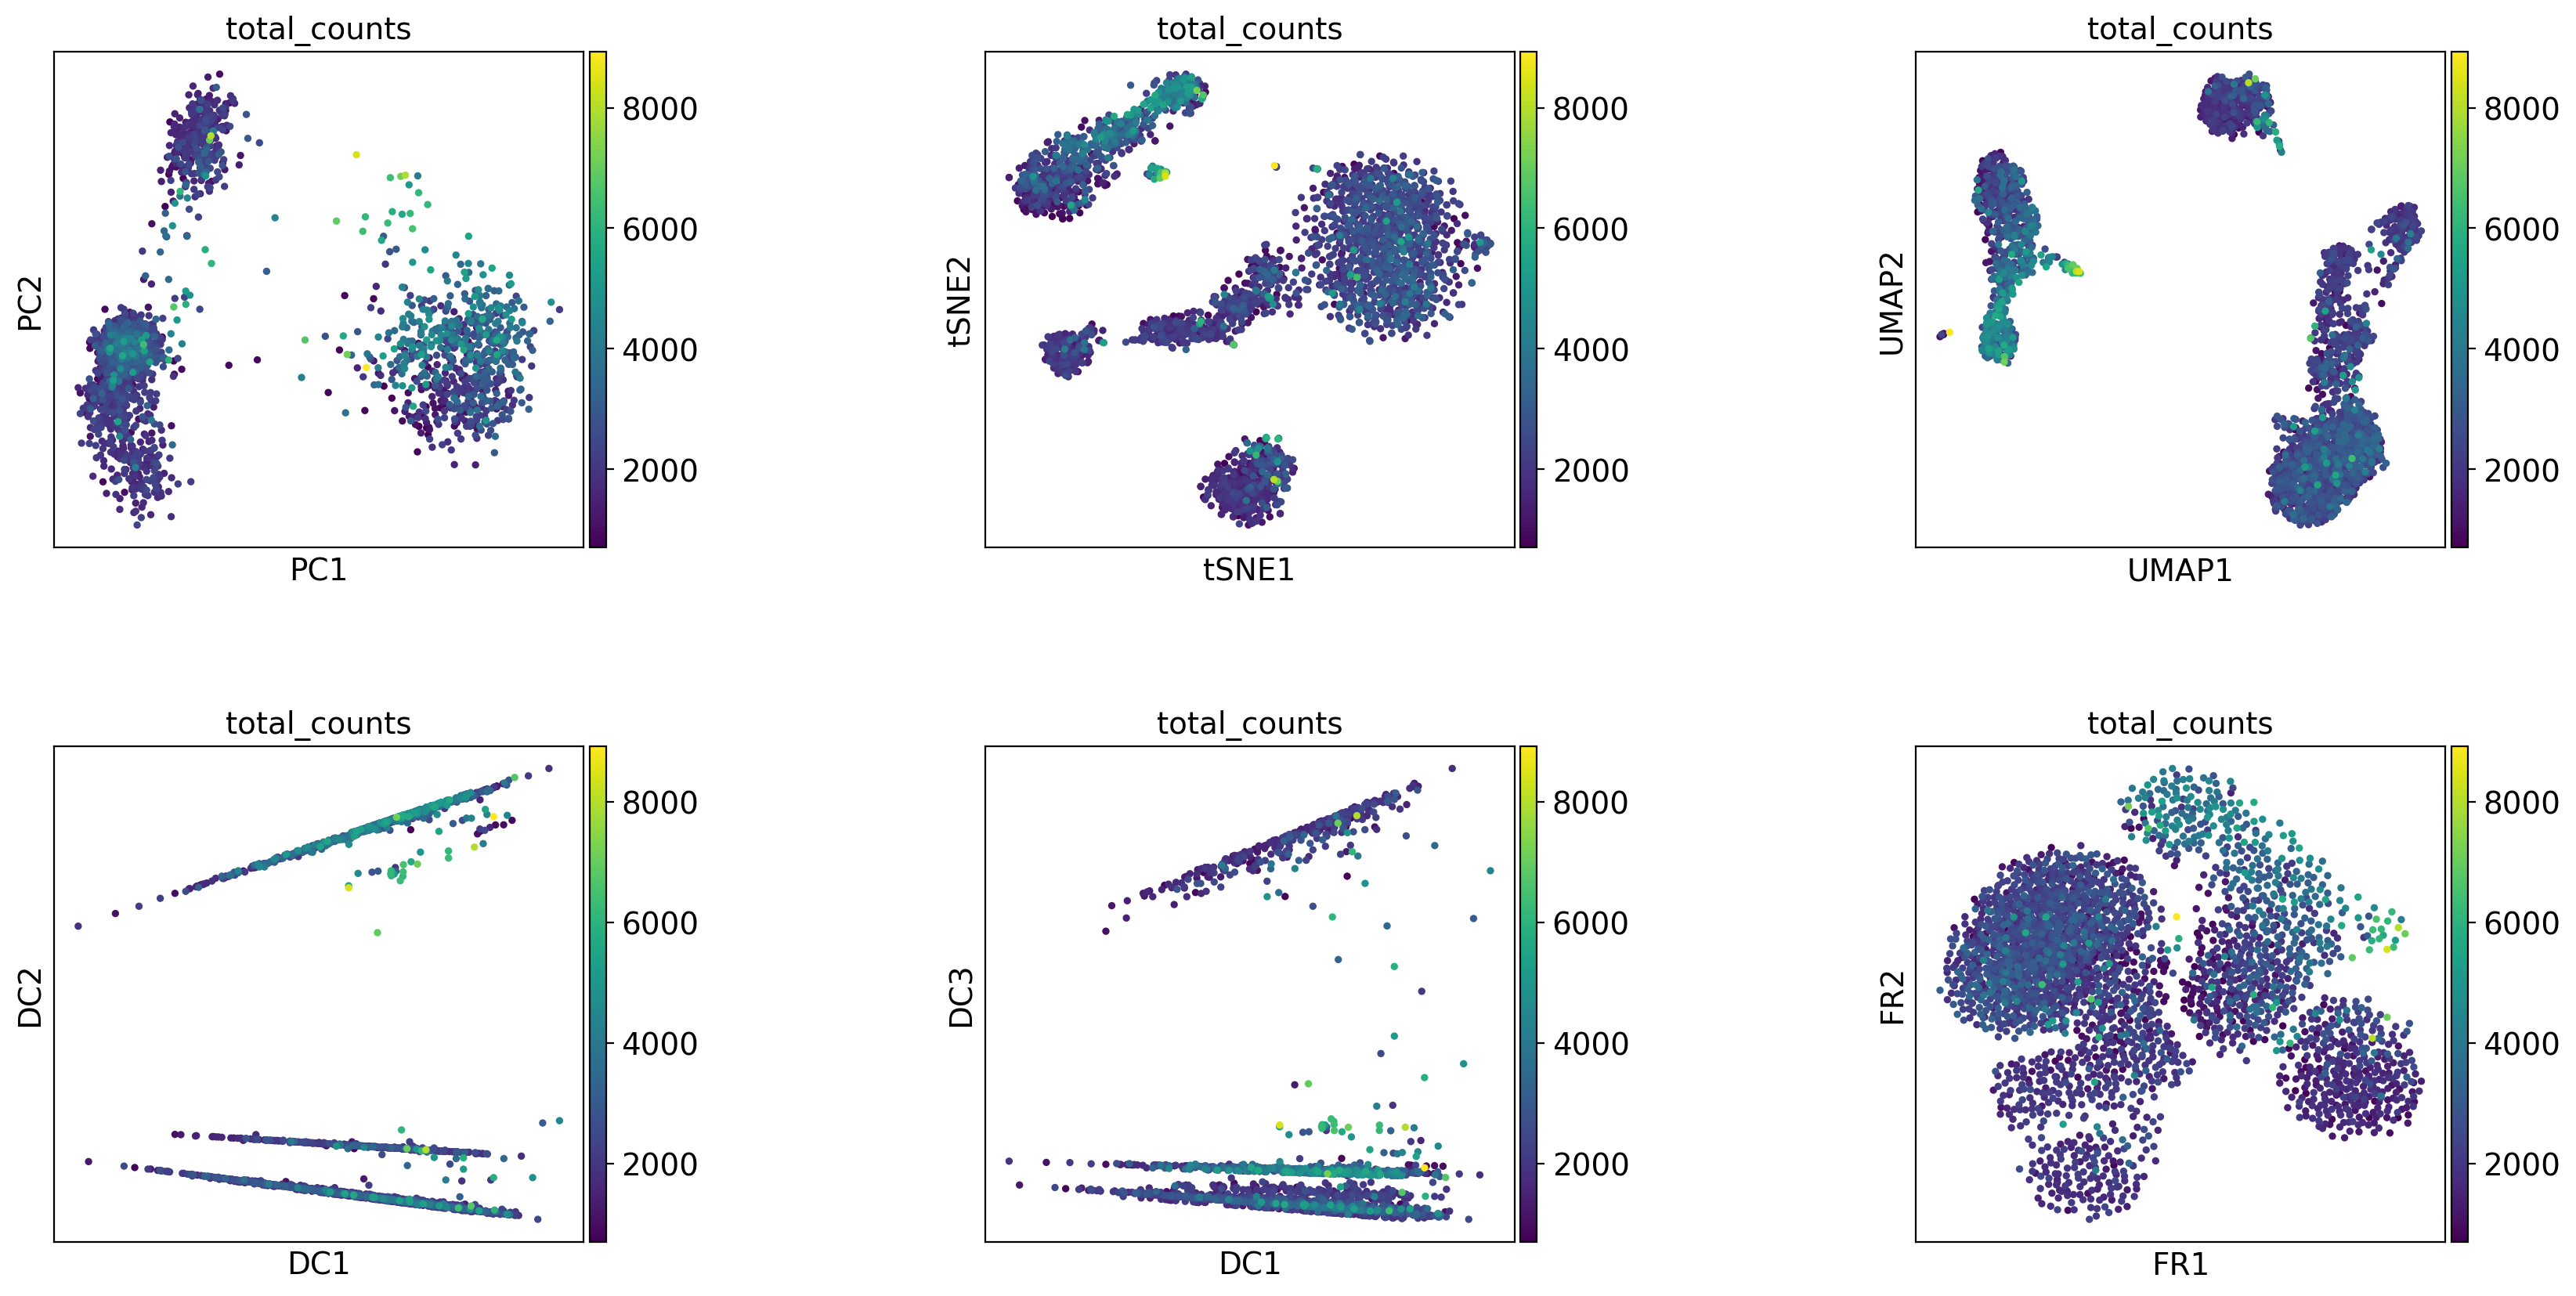

In [31]:
# Sets the overall size of the figure (width=20, height=10).
rcParams['figure.figsize'] = (20, 10)

# Creates an array of subplot indices for a 2x3 grid (subplot indices: 231, 232, ..., 236).
fig_ind = np.arange(231, 237)

# Initializes a new Matplotlib figure.
fig = plt.figure()

# Adjusts the spacing between subplots:
# - hspace (height spacing) = 0.4
# - wspace (width spacing) = 0.6

fig.subplots_adjust(hspace=0.4, wspace=0.6)
# PCA Scatter Plot:
# - Visualizes the data in the PCA space (principal components).
# - Colors points by 'total_counts' to show gene expression variation.
# - Plots on the first subplot (index 231).

p10 = sc.pl.pca_scatter(adata, color='total_counts', ax=fig.add_subplot(fig_ind[0]), show=False)
# t-SNE Plot:
# - Embeds the data into a 2D space using t-SNE.
# - Colors points by 'total_counts' for comparison.
# - Plots on the second subplot (index 232).
p11 = sc.pl.tsne(adata, color='total_counts', ax=fig.add_subplot(fig_ind[1]), show=False)
# UMAP Plot:
# - Visualizes the data in a 2D UMAP embedding.
# - Colors points by 'total_counts' to highlight patterns.
# - Plots on the third subplot (index 233).
p12 = sc.pl.umap(adata, color='total_counts', ax=fig.add_subplot(fig_ind[2]), show=False)
# Diffusion Map Plot (Components 1 vs. 2):
# - Uses Diffusion Map to identify continuous transitions or trajectories.
# - Colors points by 'total_counts'.
# - Plots on the fourth subplot (index 234).
p13 = sc.pl.diffmap(adata, color='total_counts', components=['1,2'], ax=fig.add_subplot(fig_ind[3]), show=False)
# Diffusion Map Plot (Components 1 vs. 3):
# - Plots a different combination of Diffusion Map components (1 and 3).
# - Colors points by 'total_counts'.
# - Plots on the fifth subplot (index 235).
p14 = sc.pl.diffmap(adata, color='total_counts', components=['1,3'], ax=fig.add_subplot(fig_ind[4]), show=False)
# Force-Directed Graph Layout:
# - Visualizes the neighborhood graph of cells using a force-directed layout.
# - Colors points by 'total_counts'.
# - Plots on the sixth subplot (index 236).
p15 = sc.pl.draw_graph(adata, color='total_counts', ax=fig.add_subplot(fig_ind[5]), show=False)
plt.show()

At this point of the analysis, we have reached an important milestone as we finished the pre-processing and enter the downstream analysis part. **Ideally, we don't have to revisit this part again.**

# Downstream analysis

## Clustering

Clustering is a central component of the scRNA-seq analysis pipeline. To understand the data, we must identify cell types and states present. The first step of doing so is clustering. Performing Modularity optimization by Louvain community detection on the k-nearest-neighbour graph of cells has become an established practice in scRNA-seq analysis. Thus, this is the method of choice in this tutorial as well.

Here, we perform clustering at two resolutions. Investigating several resolutions allows us to select a clustering that appears to capture the main clusters in the visualization and can provide a good baseline for further subclustering of the data to identify more specific substructure.

Clustering is performed on the highly variable gene data, dimensionality reduced by PCA, and embedded into a KNN graph. (see `sc.pp.pca()` and `sc.pp.neighbors()` functions used in the visualization section).

Compute a `louvain` clustering with two different resolutions (`0.5` and `1.5`). Compare the clusterings in a table and visualize the clustering in an embedding. Optional: Compute a clustering with the `leiden` algorithm.

In [32]:
# Perform clustering - using highly variable genes
sc.tl.leiden(adata, resolution=1.5, key_added='leiden_r1.5')
sc.tl.leiden(adata, resolution=0.5, key_added='leiden_r0.5')

running Leiden clustering


<ipython-input-32-84aab19e96f9>:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1.5, key_added='leiden_r1.5')


    finished: found 14 clusters and added
    'leiden_r1.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden_r0.5', the cluster labels (adata.obs, categorical) (0:00:00)


In [33]:
# Creates a contingency table comparing two clustering results:
# - `leiden_r0.9`: Cluster assignments from the Leiden algorithm with resolution 0.5.
# - `leiden_r1.5`: Cluster assignments from the Leiden algorithm with resolution 1.5.
#
# The table shows:
# - Rows: Clusters from `leiden_r0.5`.
# - Columns: Clusters from `leiden_r1.5`.
# - Cell Values: The number of cells shared between a pair of clusters from the two resolutions.
#
# Purpose:
# - Compares the distribution of cells across clusters at different resolutions.
# - Helps identify whether clusters from `leiden_r0.9` split or remain stable in `leiden_r1.5`.
pd.crosstab(adata.obs['leiden_r0.5'], adata.obs['leiden_r1.5'])

leiden_r1.5    0    1    2    3    4    5    6    7    8    9   10  11  12  13
leiden_r0.5                                                                   
0              0    0  305  269  268   13  190    0    0    0    0  37   0   0
1            354    0    0    0    0    0    0    0    0    1  116   0   0   0
2              0    0    2    0    0  208    1  173    0    0    0   0   0   0
3              0  344    0    0    0    0    6    0    0    0    0   0   0   0
4              0    0    0    0    0    0    0    0    0  149   14   0   0   0
5              0    0    0    0    0    0    0    0  157    0    0   0   0   0
6              0    0    0    0    0    0    0    0    0    0    0   0  33   0
7              0    0    0    0    0    0    0    0    0    0    0   0   0   7

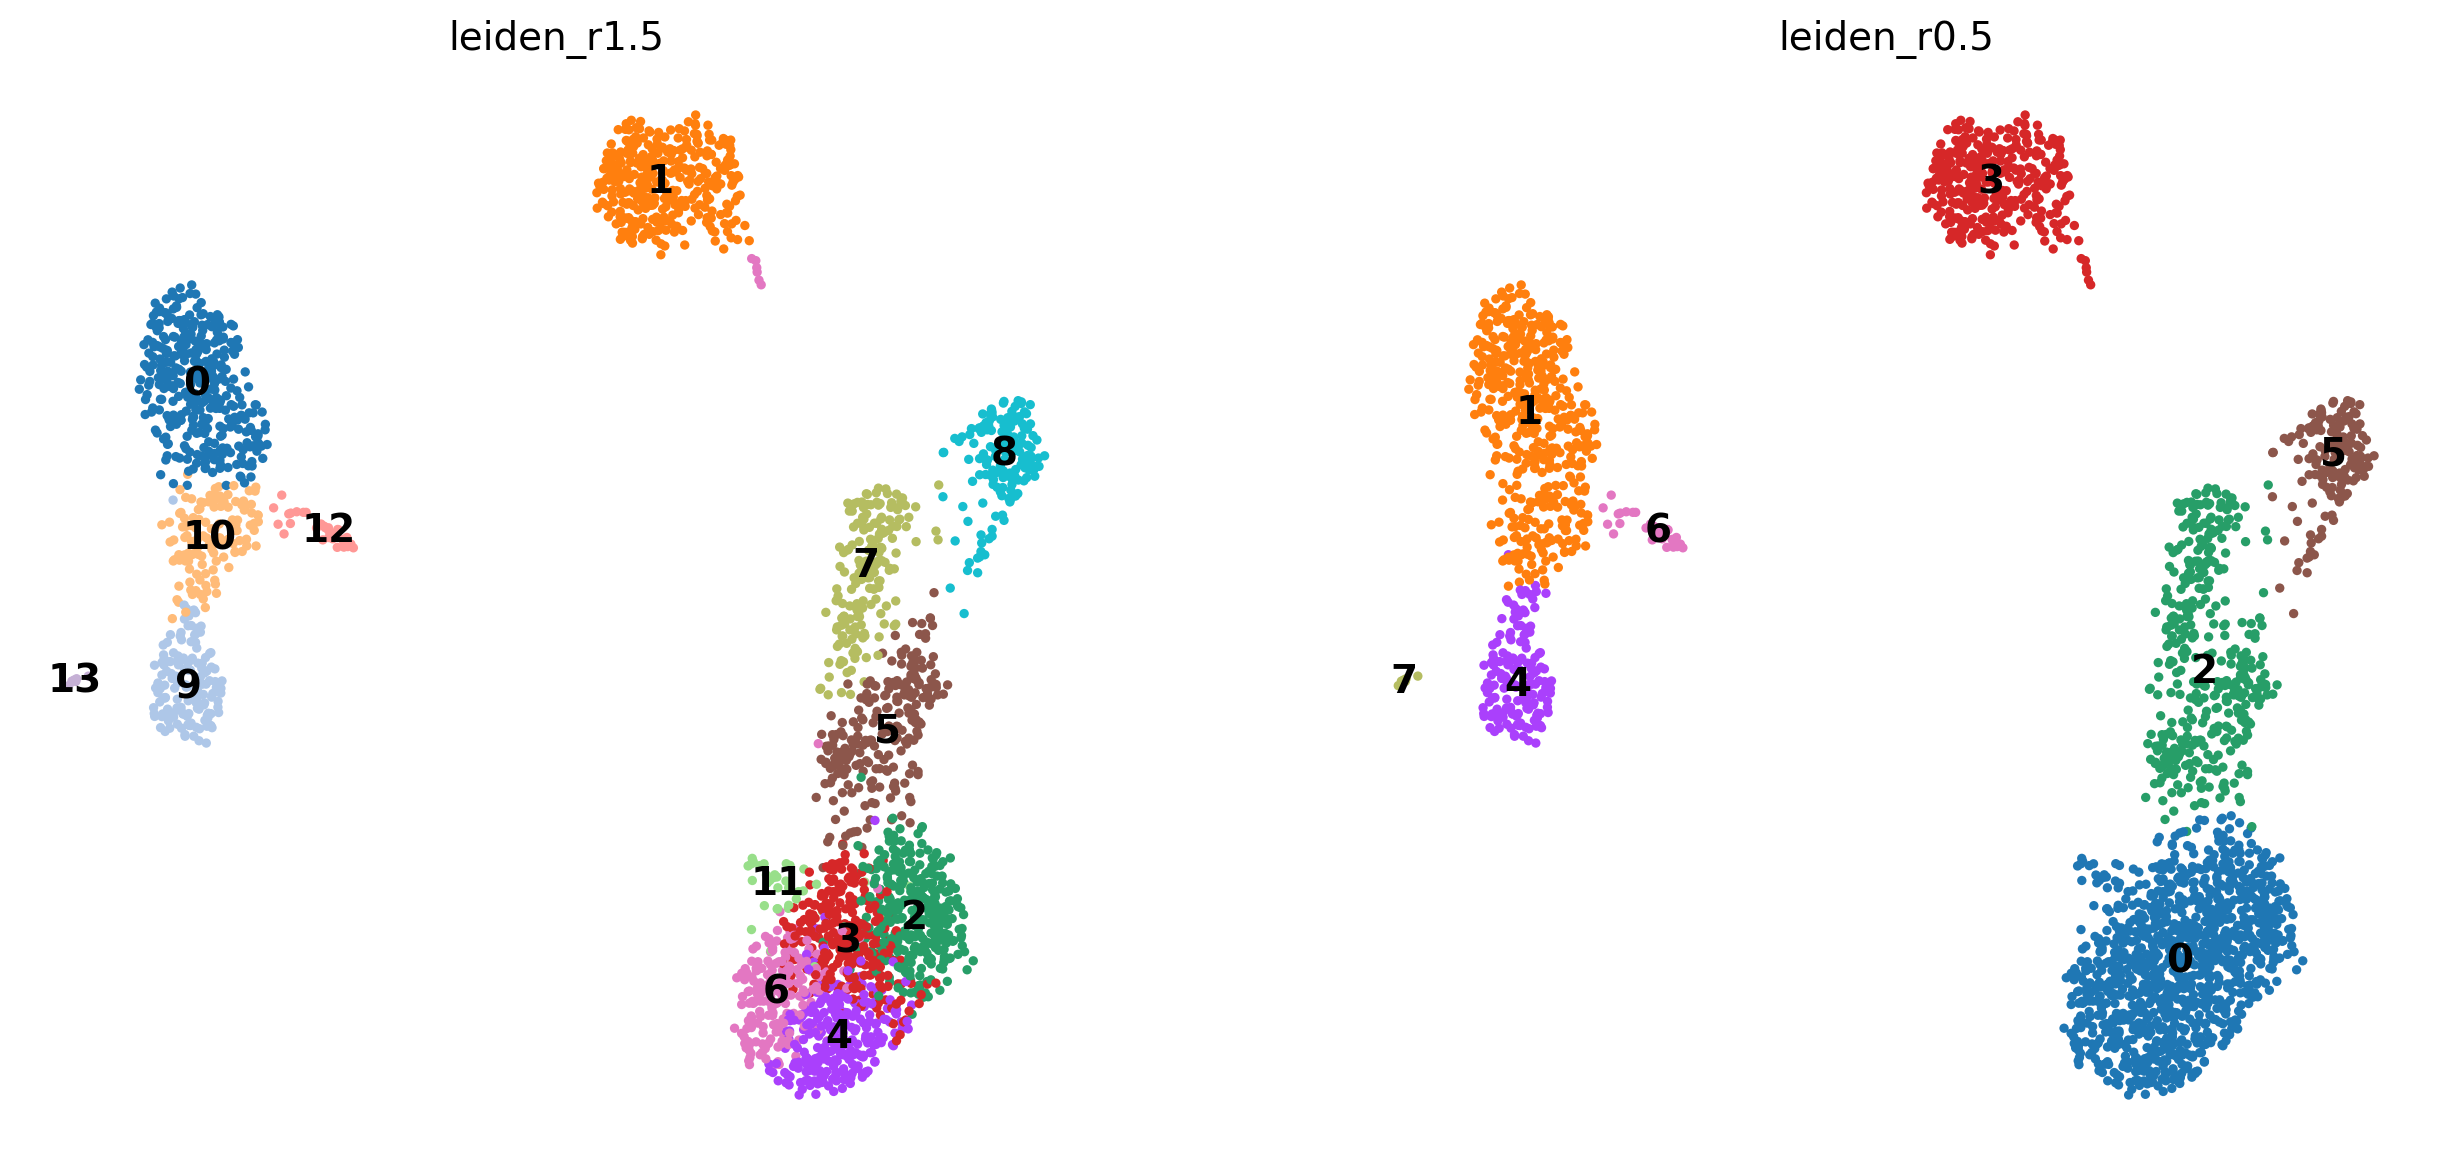

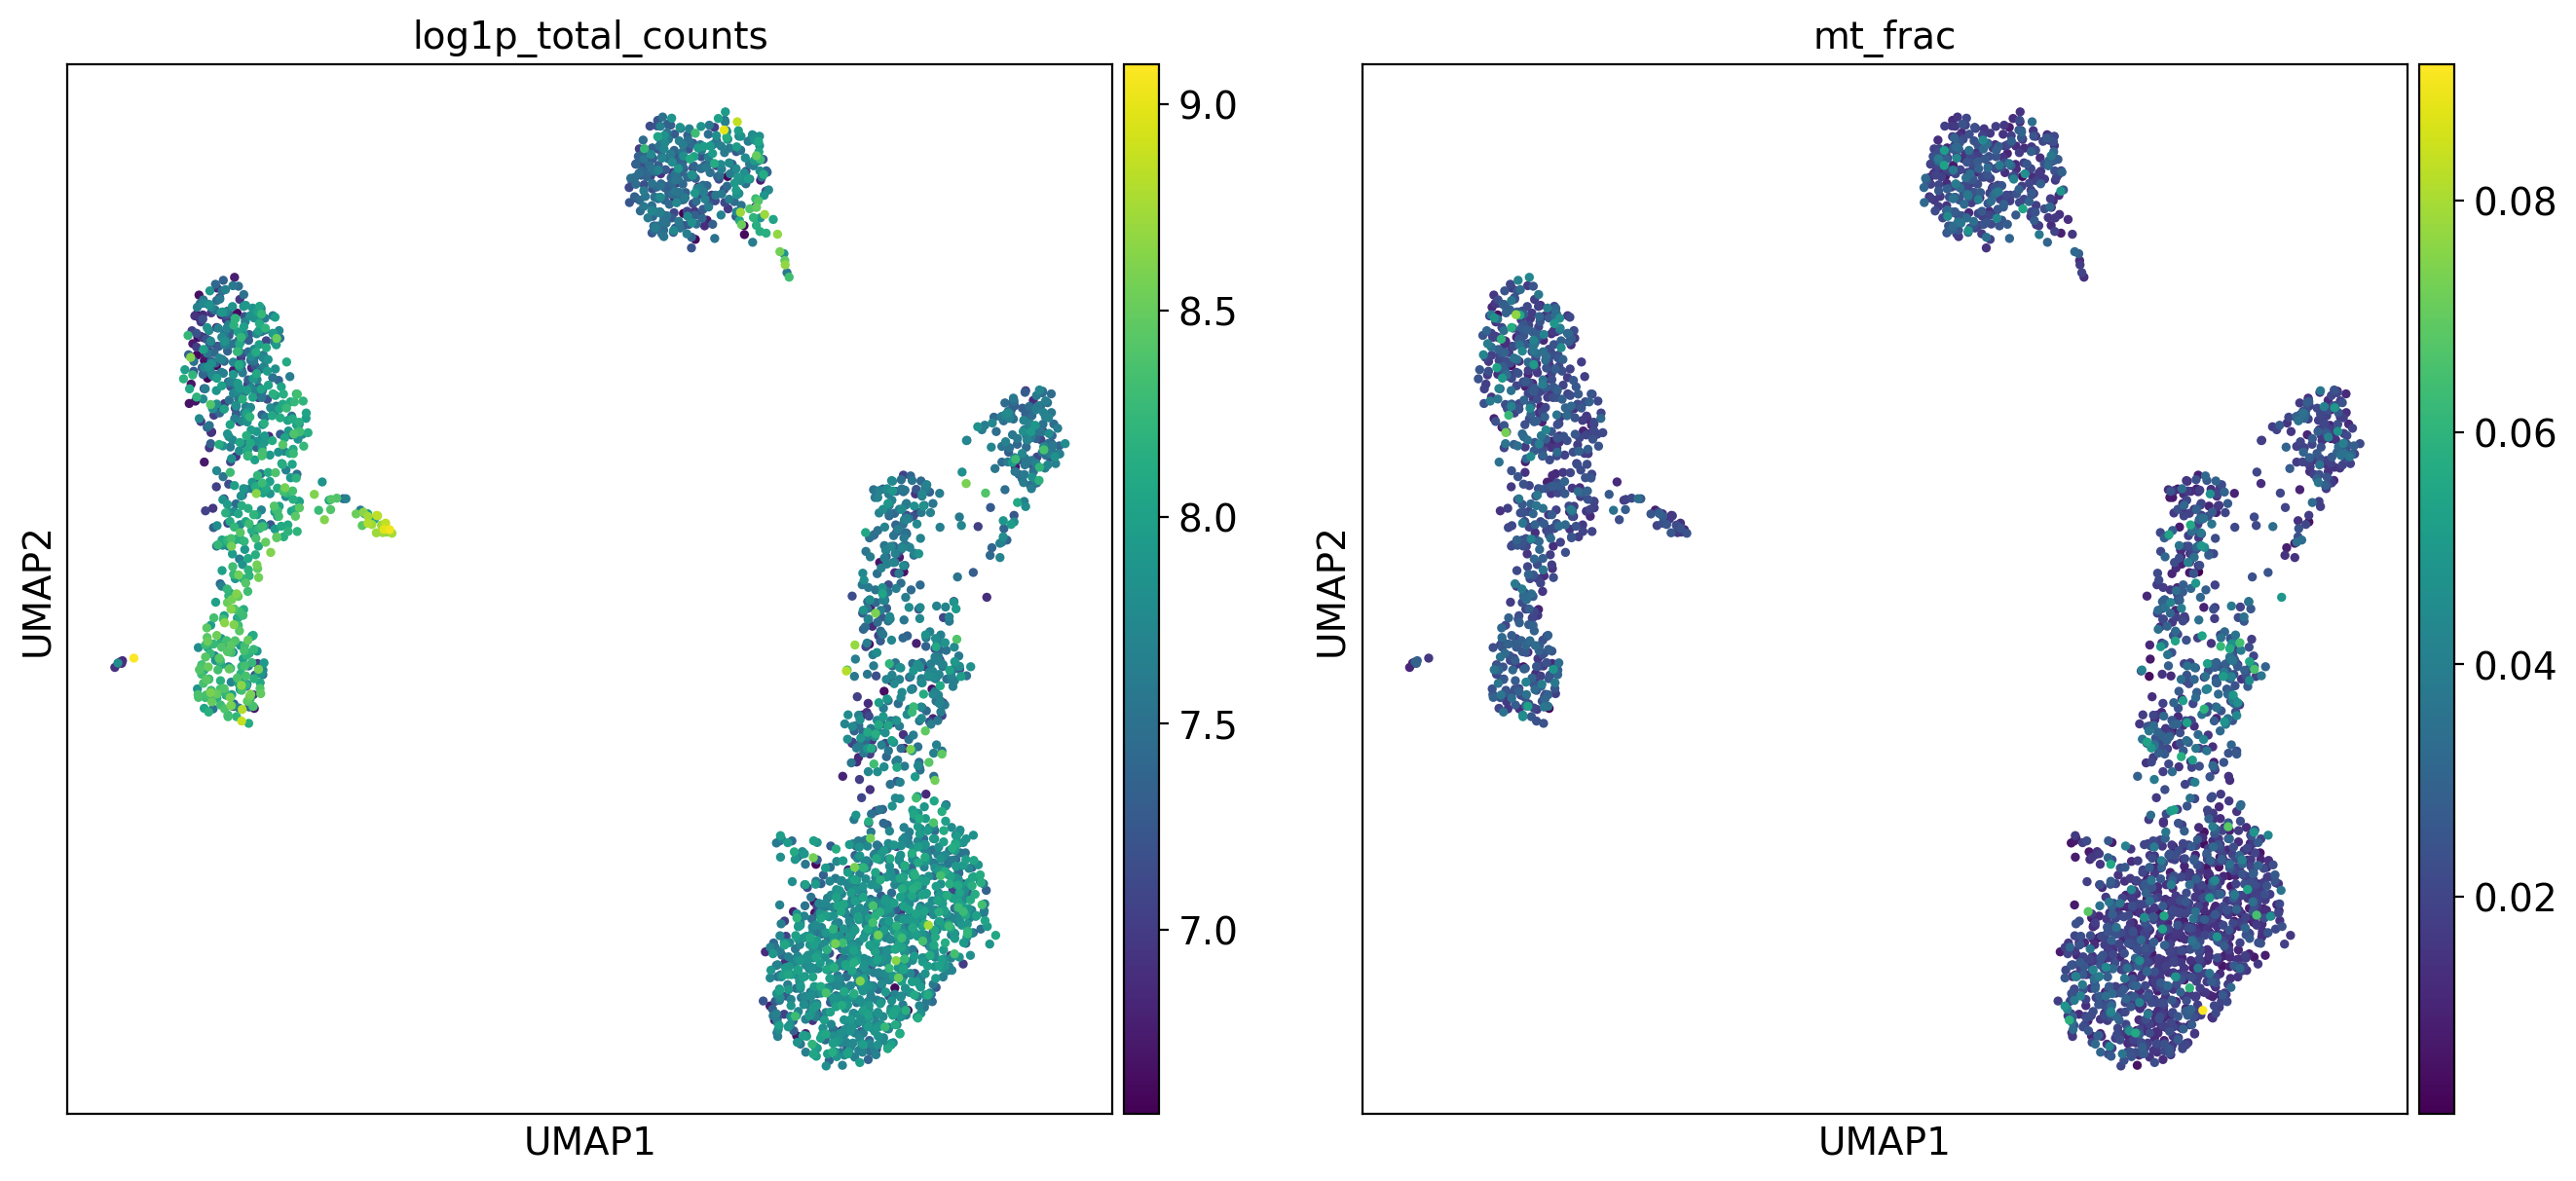

In [34]:
#Visualize the clustering and how this is reflected by different technical covariates
rcParams['figure.figsize']=(7,7)
sc.pl.umap(adata, color=['leiden_r1.5', 'leiden_r0.5'],
           legend_loc='on data',  frameon=False)
sc.pl.umap(adata, color=['log1p_total_counts', 'mt_frac'])

## Marker genes and cluster annotation

To annotate the clusters we obtained, we find genes that are up-regulated in the cluster compared to all other clusters (marker genes). This differential expression test is performed by a *Welch t-test with overestimated variance* to be conservative. This is the default in `scanpy`. The test is automatically performed on the `.raw` data set, which is uncorrected and contains all genes. All genes are taken into account, as any gene may be an informative marker.

Compute the differential expression profile for each cluster with `rank_genes_groups` and visualize the results.

In [35]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='leiden_r0.5', key_added='rank_genes_r0.5')

ranking genes
    finished: added to `.uns['rank_genes_r0.5']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [36]:
##save_the_top_geens
result = adata.uns["rank_genes_r0.5"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        f"{group}_{key[:1]}": result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(5)

0_n            0_p     1_n            1_p   2_n            2_p       3_n  \
0   LDHB  2.074289e-261     LYZ   0.000000e+00  CCL5  3.873198e-229      CD74   
1  RPS25  8.690326e-224     FTL   0.000000e+00  NKG7   1.376286e-95   HLA-DRA   
2  RPS12  2.797540e-223  TYROBP   0.000000e+00  IL32  6.570096e-102  HLA-DPB1   
3  RPS27  2.682329e-218    CST3   0.000000e+00   B2M  1.063609e-103  HLA-DRB1   
4   CD3D  3.179805e-183  S100A9  2.751386e-258  GZMA   1.655008e-66     CD79A   

             3_p     4_n            4_p    5_n            5_p       6_n  \
0   0.000000e+00    LST1  5.596621e-148   NKG7  6.115699e-156       LYZ   
1  1.015462e-295    AIF1  3.390760e-160   GNLY   6.728925e-84   HLA-DRA   
2  1.764314e-187     FTL  2.922611e-206   GZMB   2.631237e-71      CD74   
3  1.552561e-168    FTH1  1.641168e-185   CTSW   1.021039e-71      CST3   
4  1.247863e-134  FCER1G  1.579177e-122  HLA-C   1.447680e-80  HLA-DPB1   

            6_p     7_n           7_p  
0  1.561131e-31    MPP1  3.015762e-08  
1  3.462239e-27    OAZ1  1.123835e-07  
2  2.975975e-26   RUFY1  2.813043e-07  
3  1.799408e-24    SDPR  7.149211e-07  
4  1.632629e-22  MYL12A  7.832394e-07

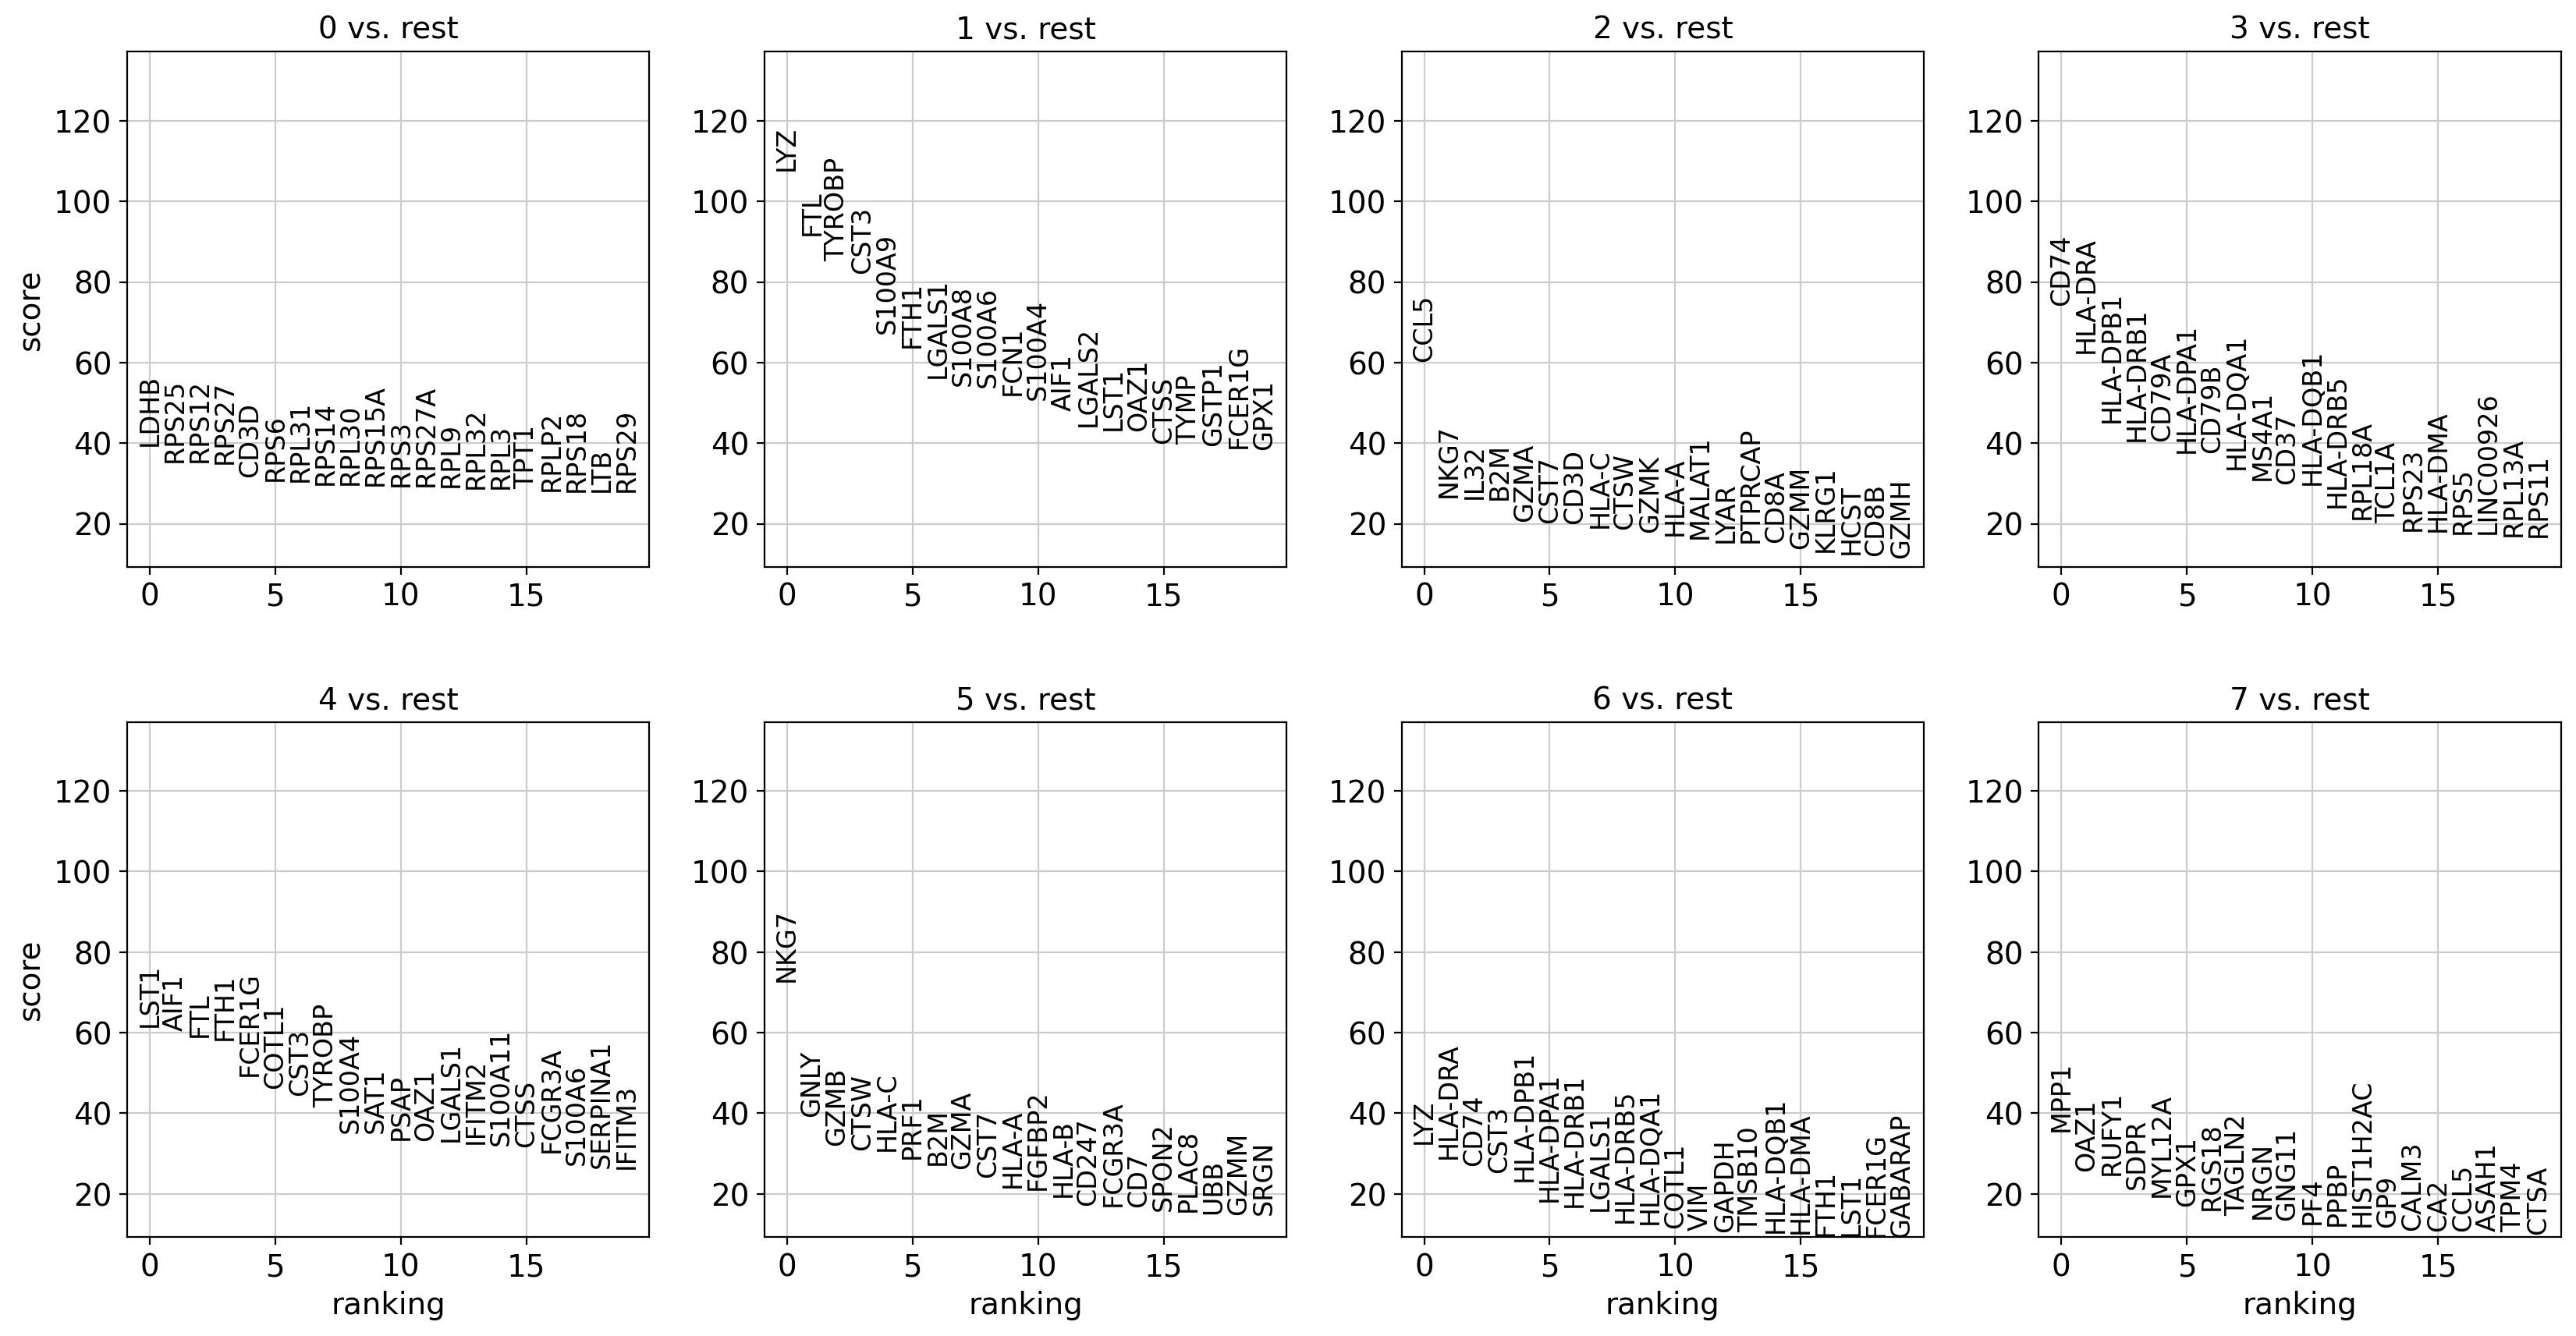

In [37]:
#Plot marker genes
rcParams['figure.figsize']=(5,5)
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5', fontsize=12)
#if you want to select one group
#sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5', fontsize=12,groups='2')

In [38]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='leiden_r1.5', key_added='rank_genes_r1.5')

ranking genes
    finished: added to `.uns['rank_genes_r1.5']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


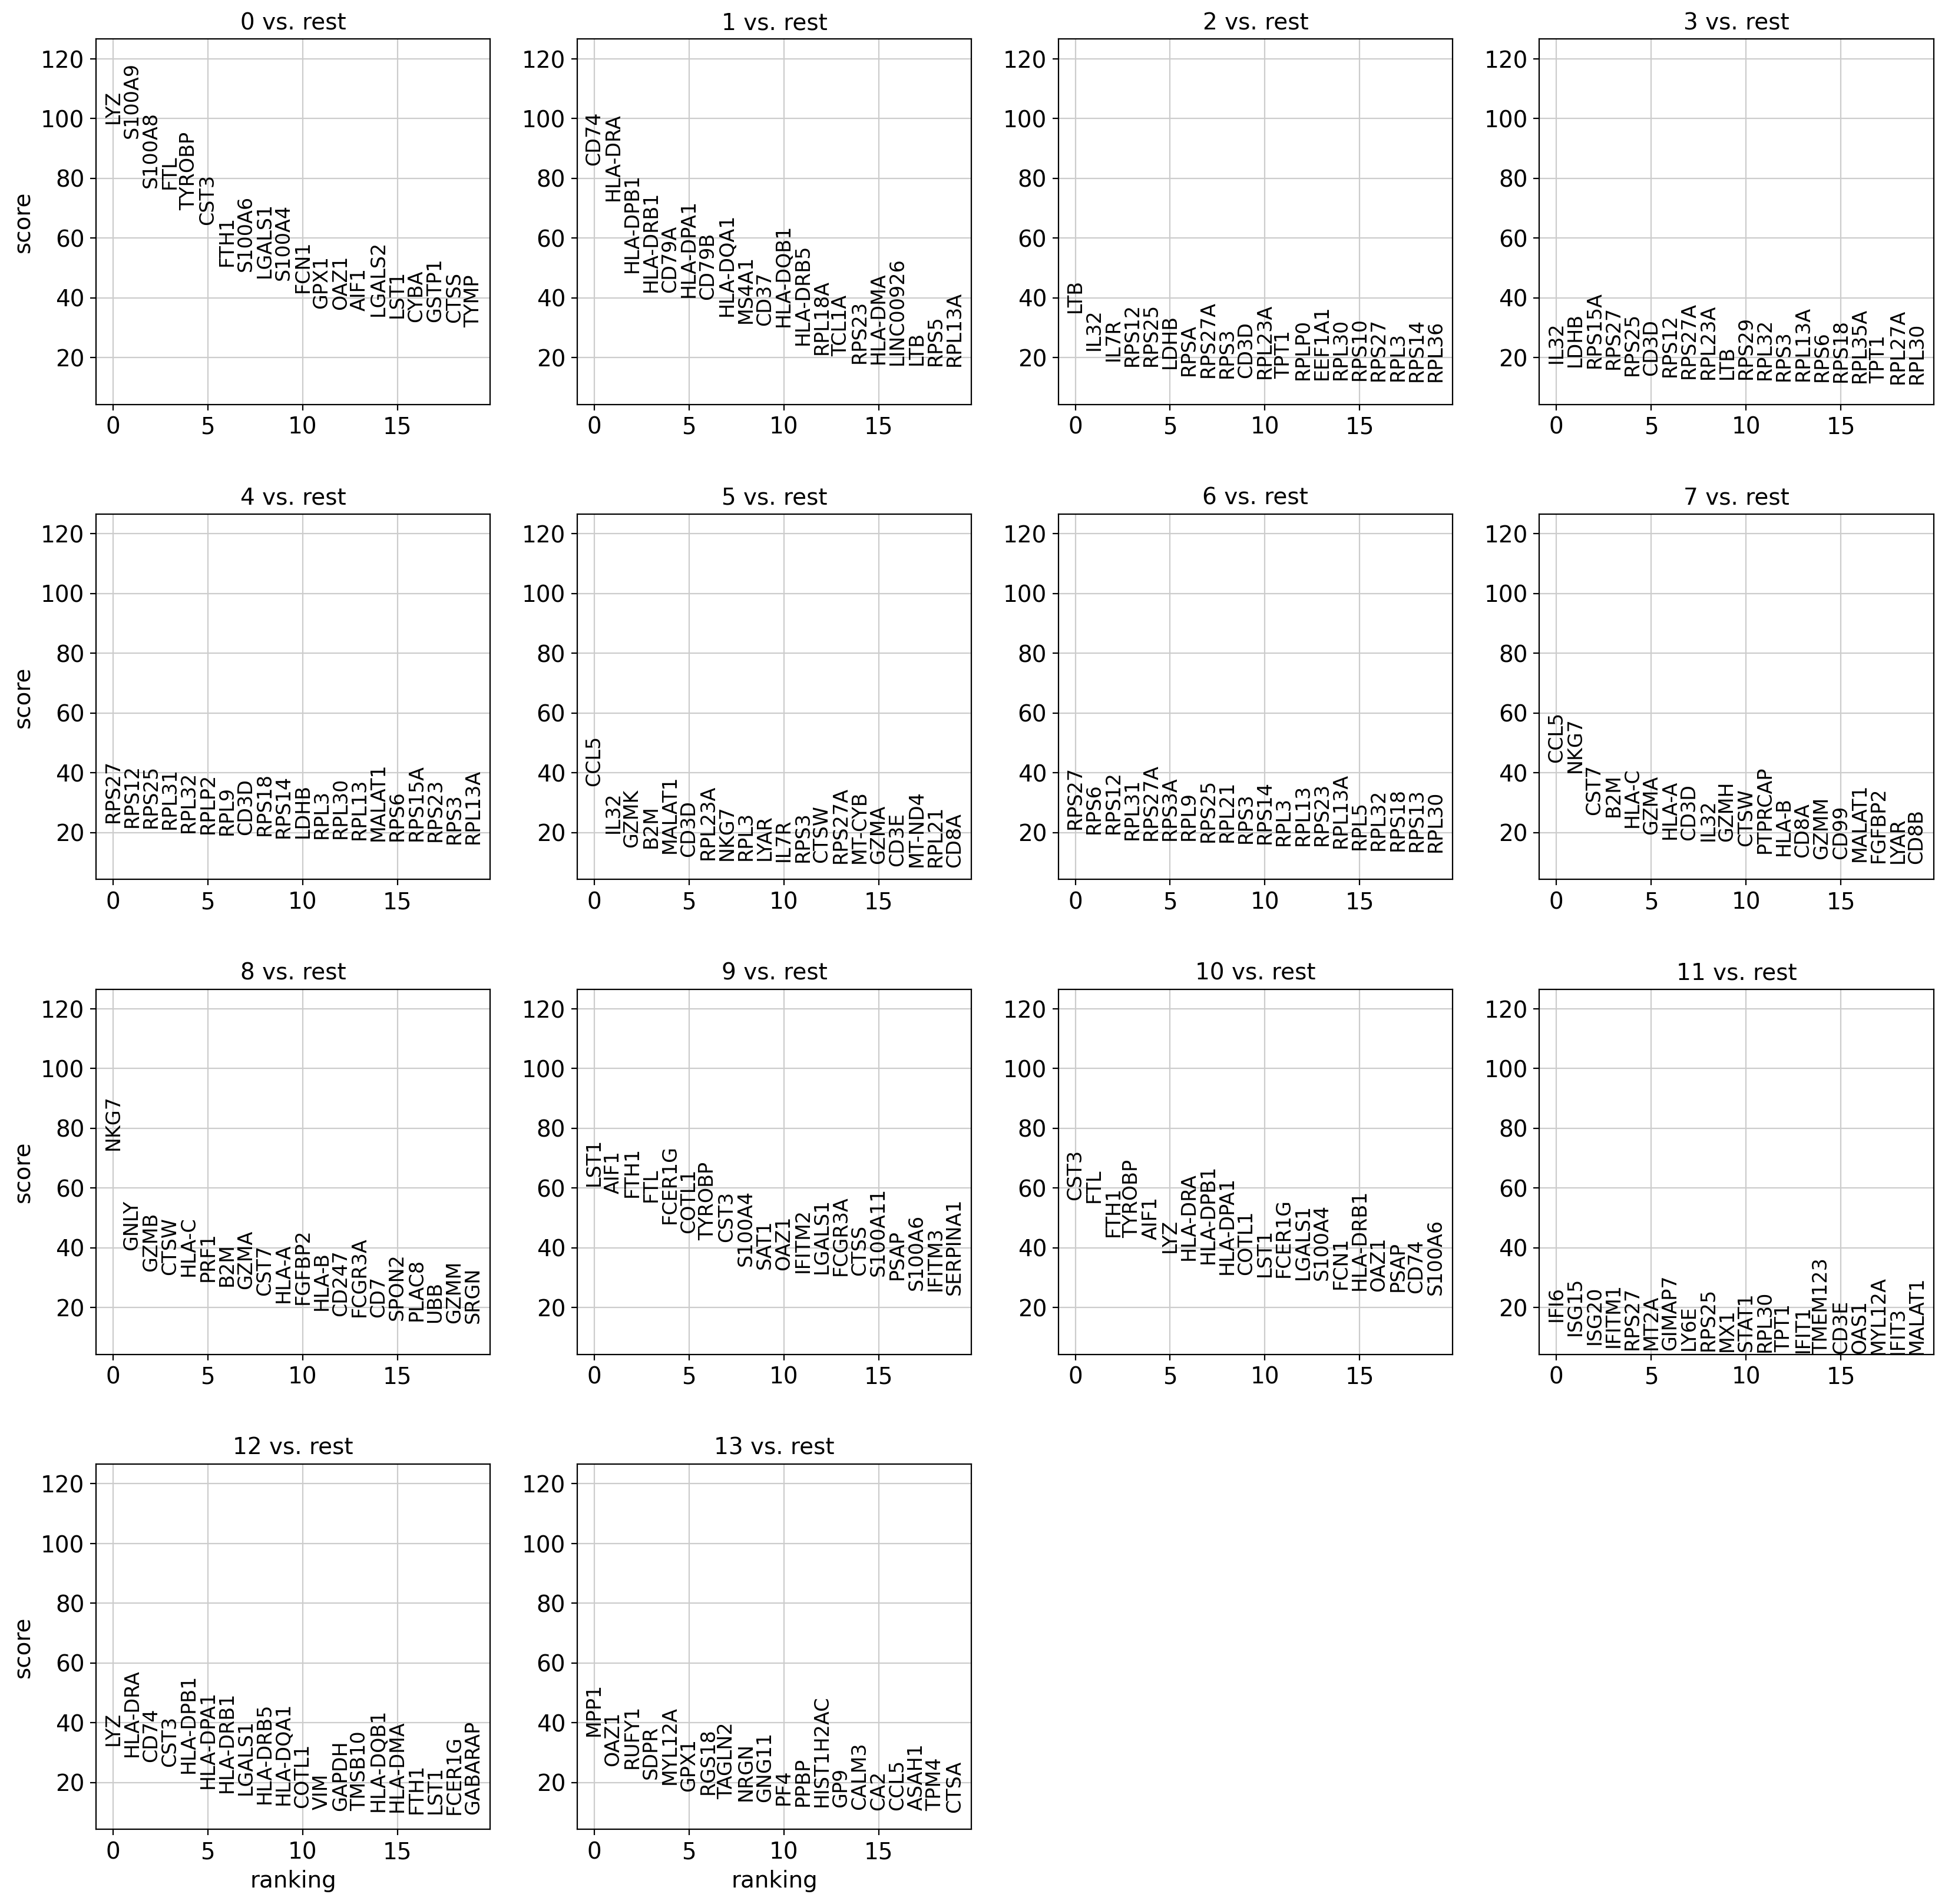

In [39]:
#Plot marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r1.5', fontsize=12)

Here, we observe a considerable ribosomal proteins (*RPL* and *RPS*), which are part of the ribosomes. Thus, they are involved in mRNA translational processes. Usually, these genes are difficult to interpret.

When it comes to cluster annotation, we have to tap into prior knowledge of the cell type. Depending on the data set, this may involve extensive literature search. In the case of PBMCs, we may refer to several studies and single-cell RNA-sequencing data analysis tutorials to extract marker gene sets.

The following list is extracted from the Seurat tutorial on PBMCs.


|Marker Gene|Cell Type|
|---------|-------|
|IL7R|CD4 T cells|
|CD14, LYZ|CD14+ Monocytes|
|MS4A1|B cells|
|CD8A|CD8 T cells|
|FCGR3A, MS4A7|FCGR3A+ Monocytes|
|GNLY, NKG7|NK cells|
|FCER1A, CST3|Dendritic Cells|
|PPBP|Megakaryocytes|


Let us define a list of marker genes from literature.

In [40]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [41]:
#Let us check if the marker genes are expressed in our dataset.
np.in1d(marker_genes, adata.var_names)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

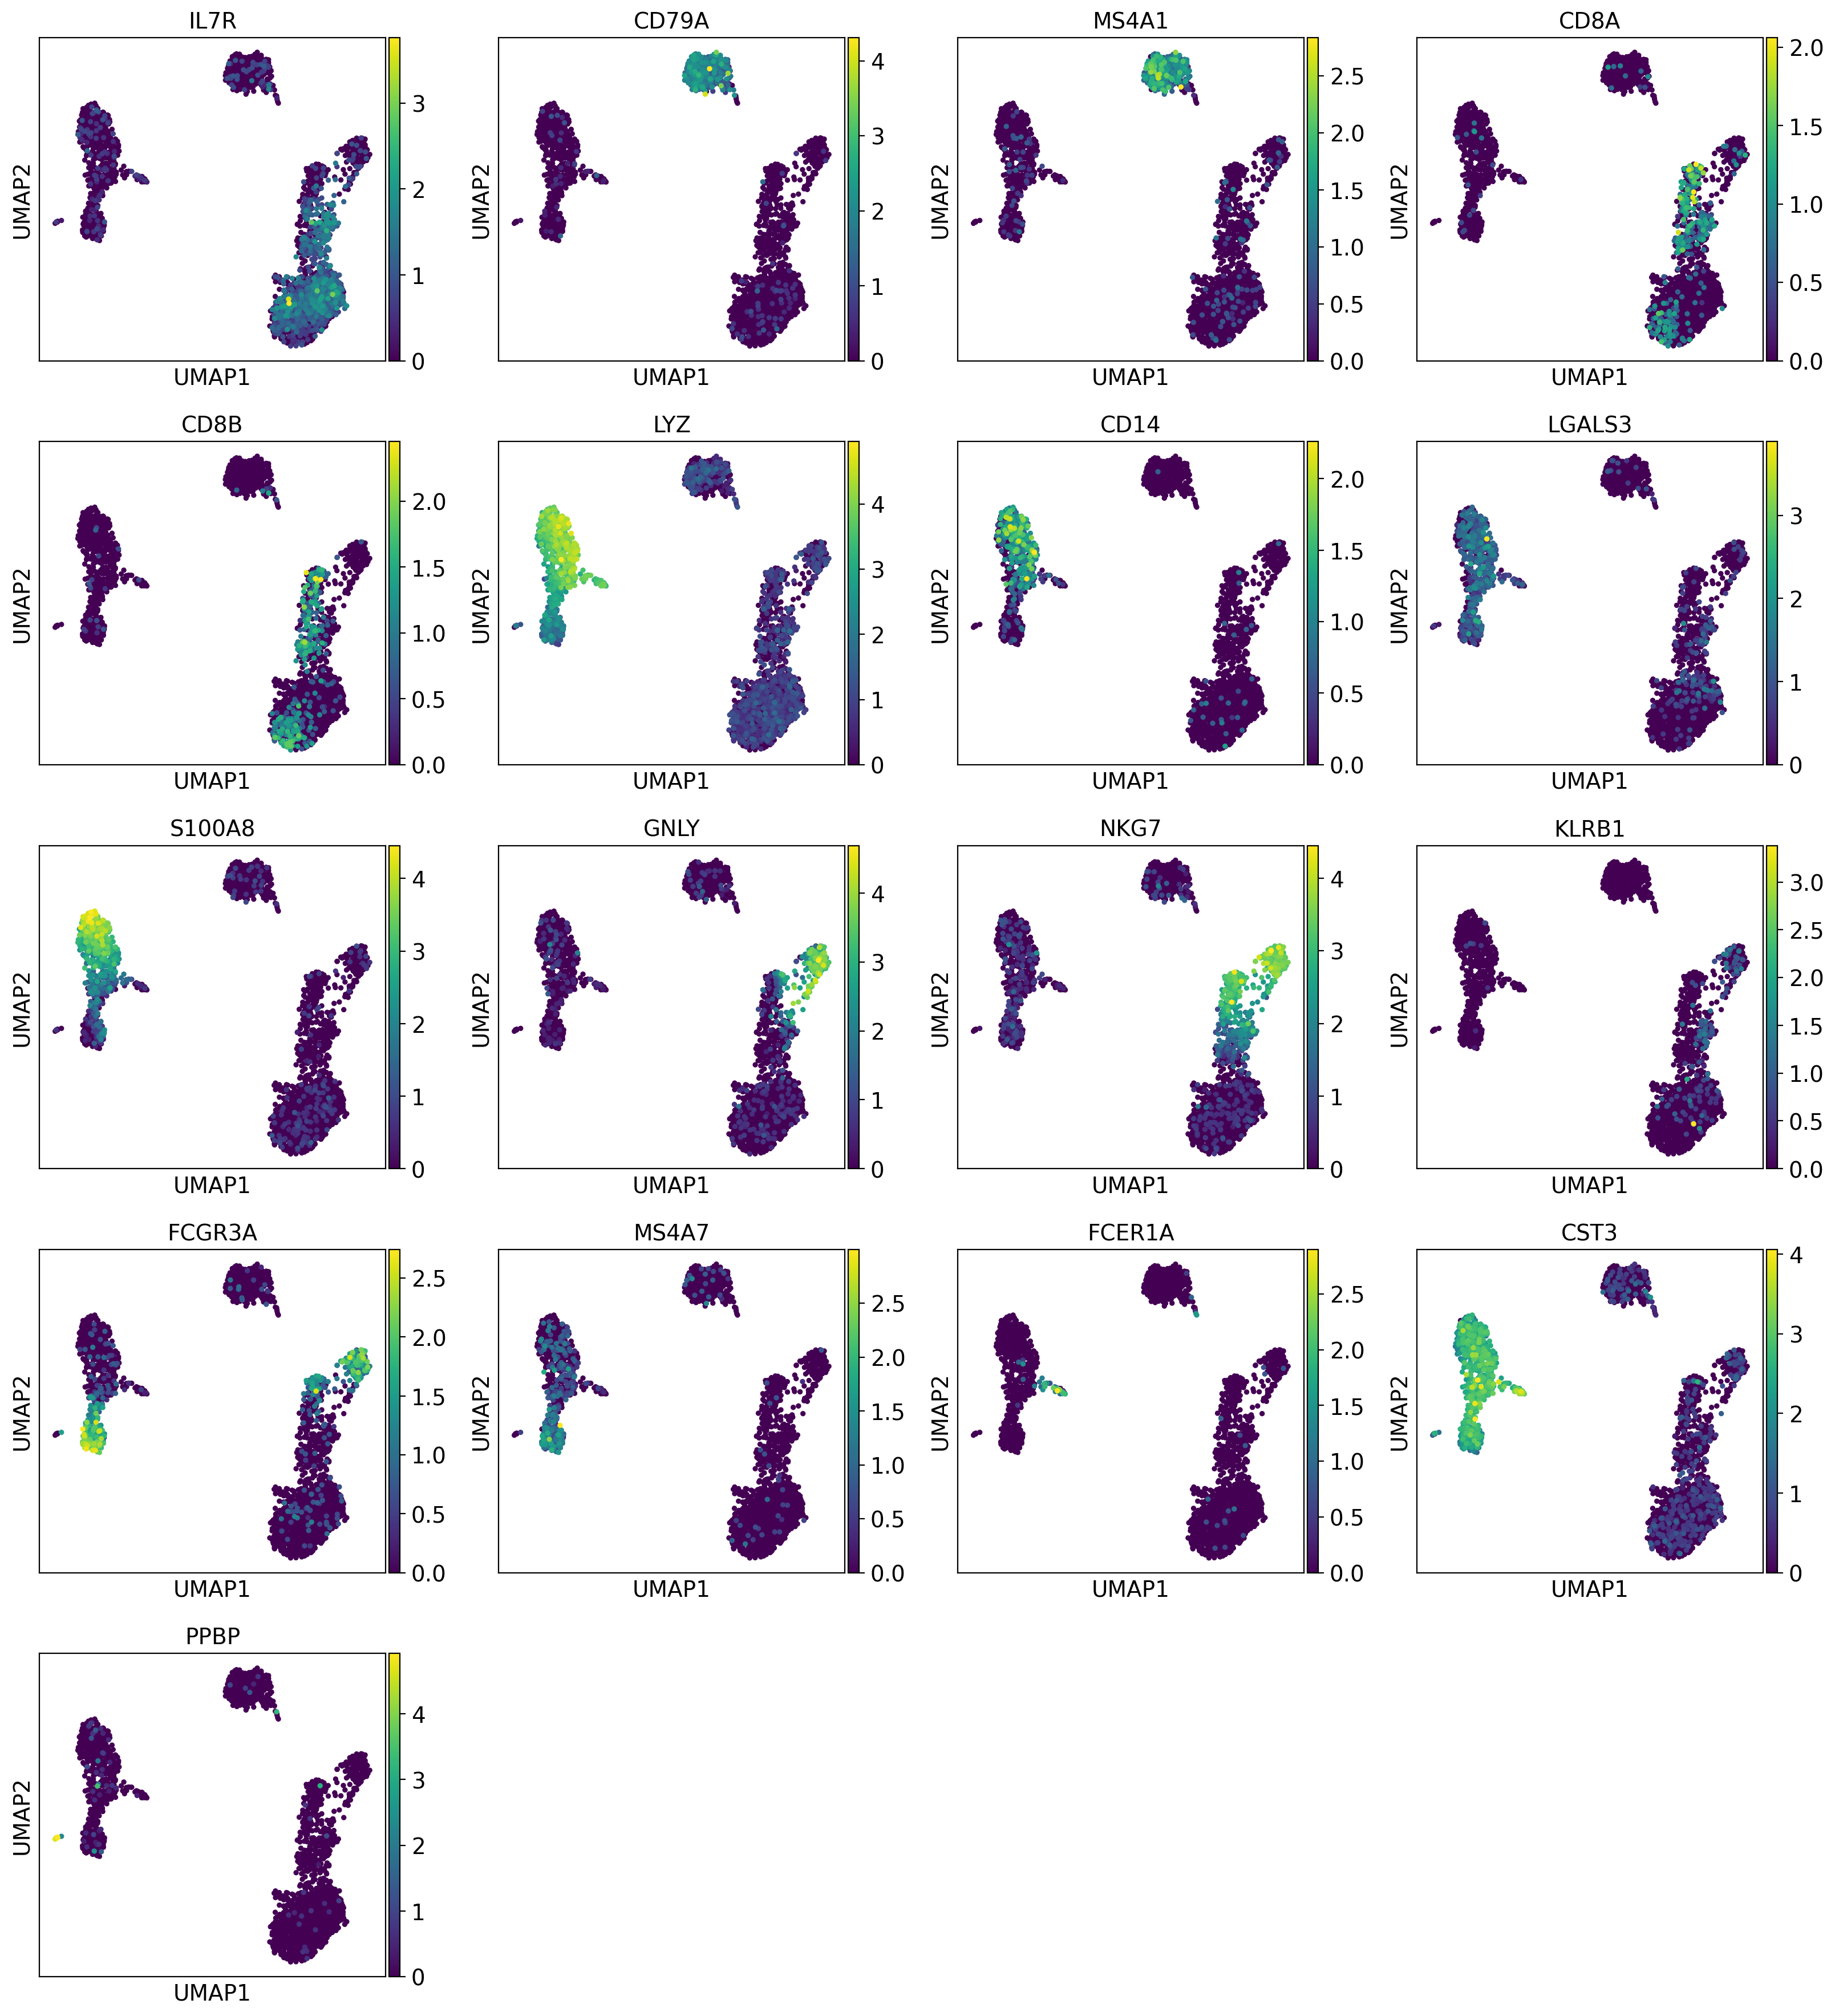

In [42]:
rcParams['figure.figsize']=(4,4)
sc.pl.umap(adata=adata, color=marker_genes, use_raw=False)

In [43]:
#The context 'paper' ensures that the plots are optimized for inclusion in publications or printed documents.
sb.set_context(context='paper')

    using 'X_pca' with n_pcs = 40
Storing dendrogram info using `.uns['dendrogram_leiden_r0.5']`


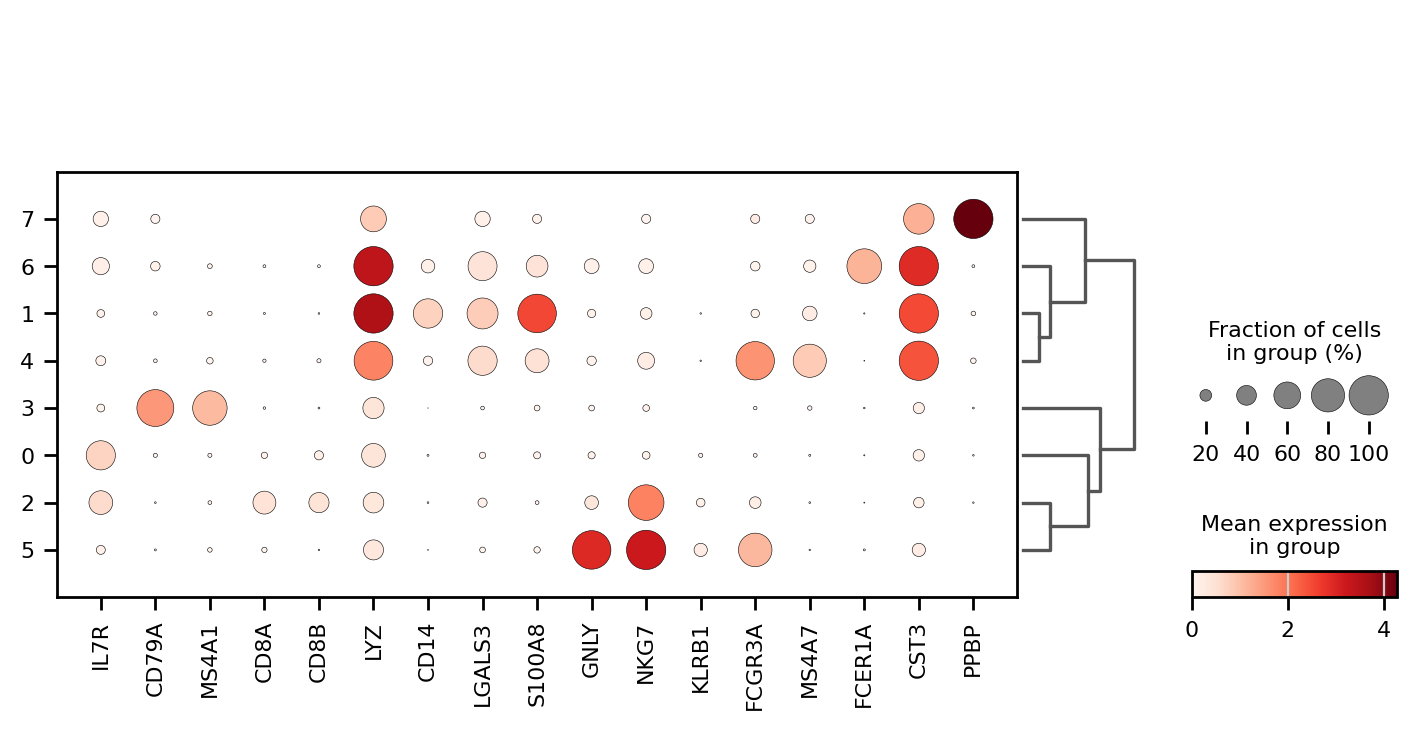

In [44]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden_r0.5', dendrogram=True)

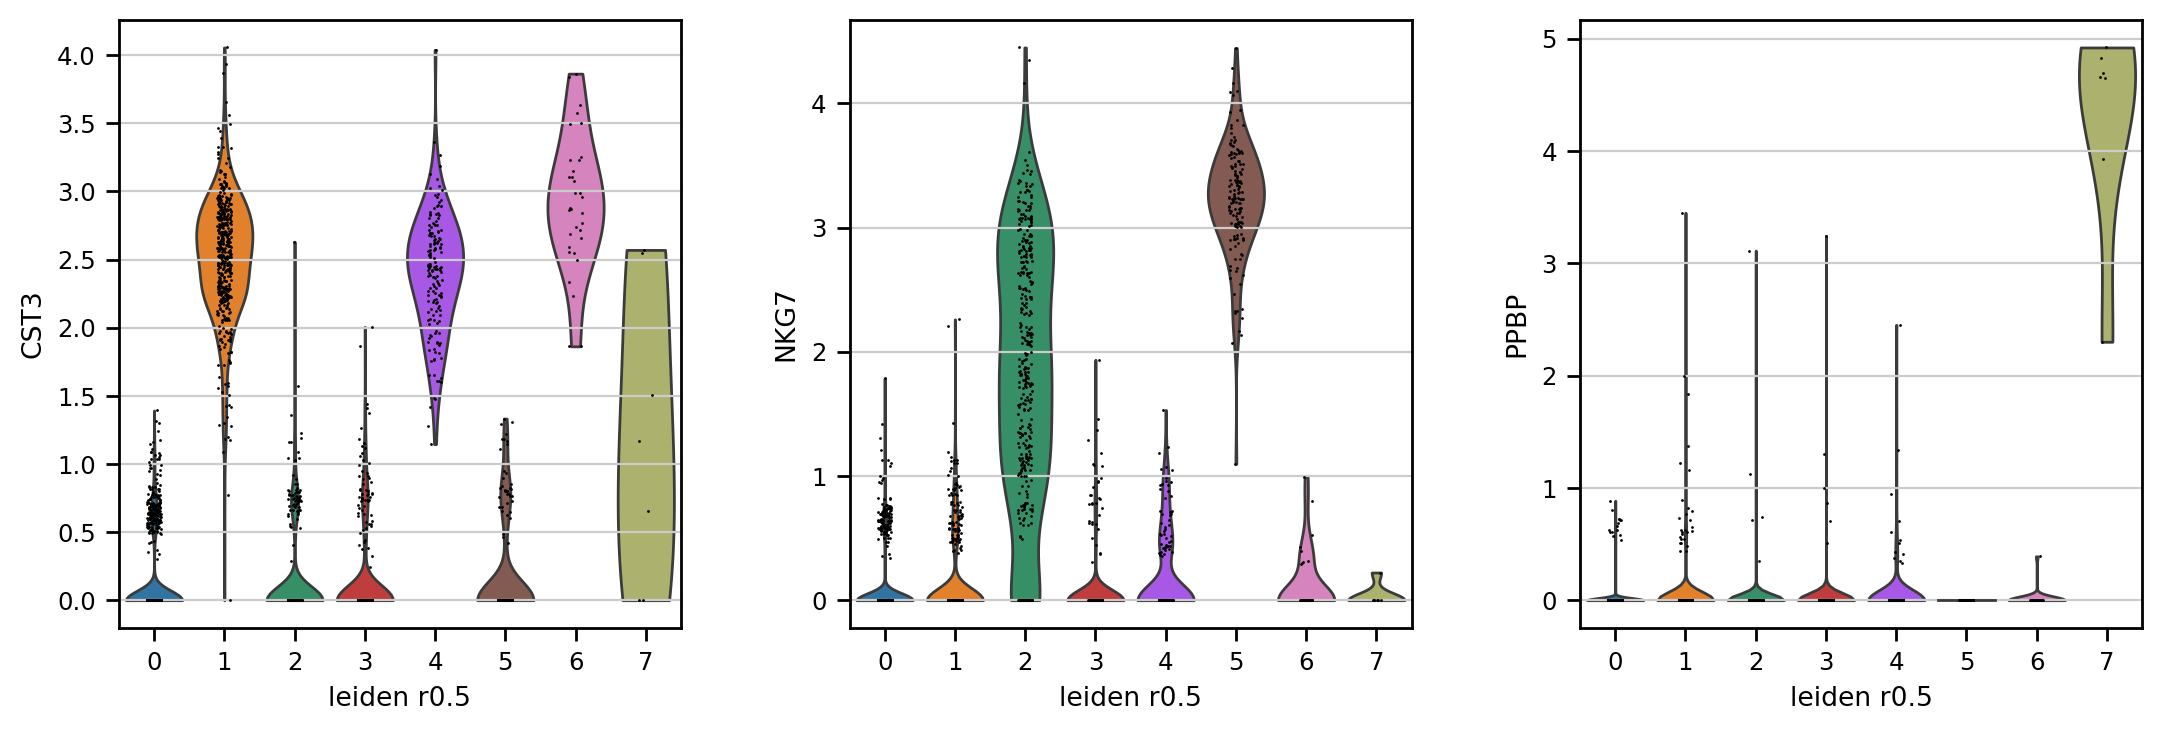

In [45]:
sc.pl.violin(adata, ["CST3", "NKG7", "PPBP"], groupby="leiden_r0.5")

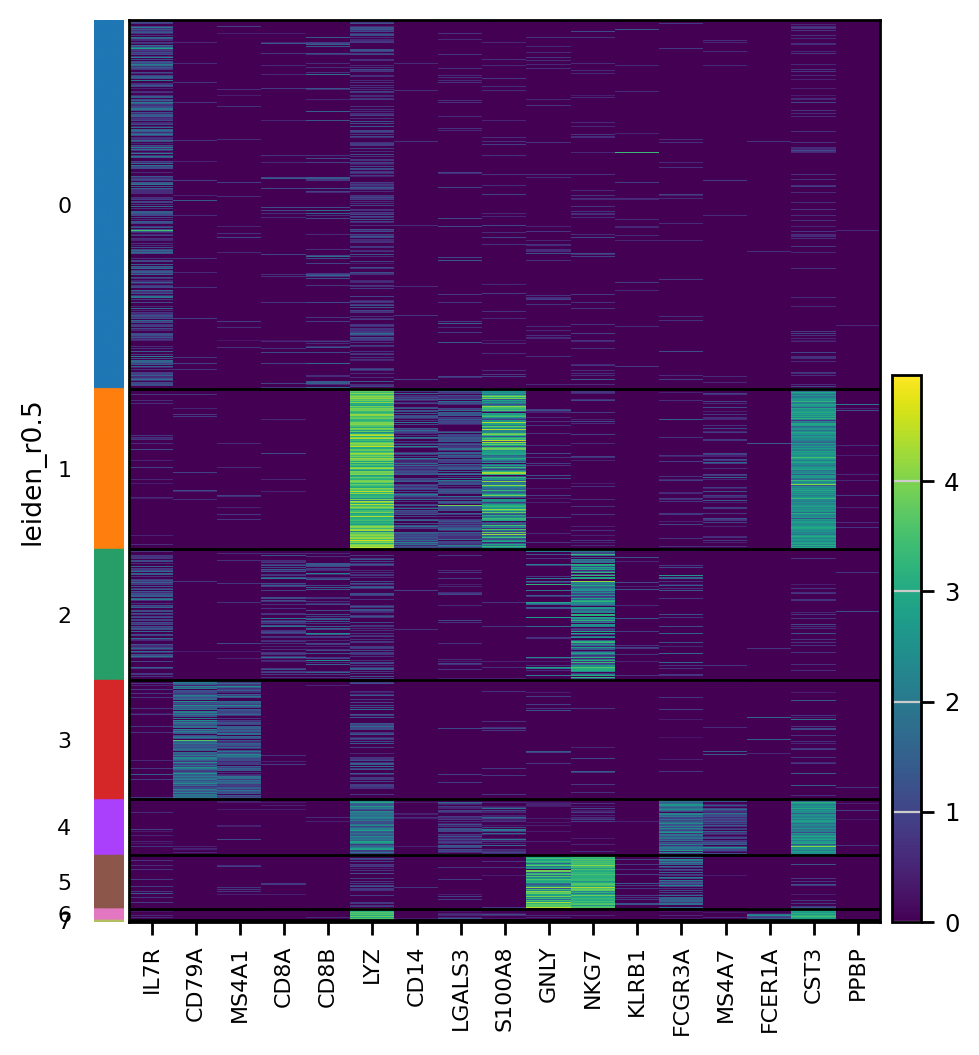

In [46]:
sc.pl.heatmap(adata=adata, var_names=marker_genes,
              groupby='leiden_r0.5', vmin=0)

In [47]:
new_cluster_names = [
    "CD4 T",
    "CD14+ Monocytes",
      "CD8 T",
    "B",
    "FCGR3A+ Monocytes",
    "NK",
    "Dendritic",
    "Megakaryocytes",
]
adata.rename_categories("leiden_r0.5", new_cluster_names)

Consider running `set_figure_params(dpi_save=...)`, which will adjust `matplotlib.rcParams['savefig.dpi']`


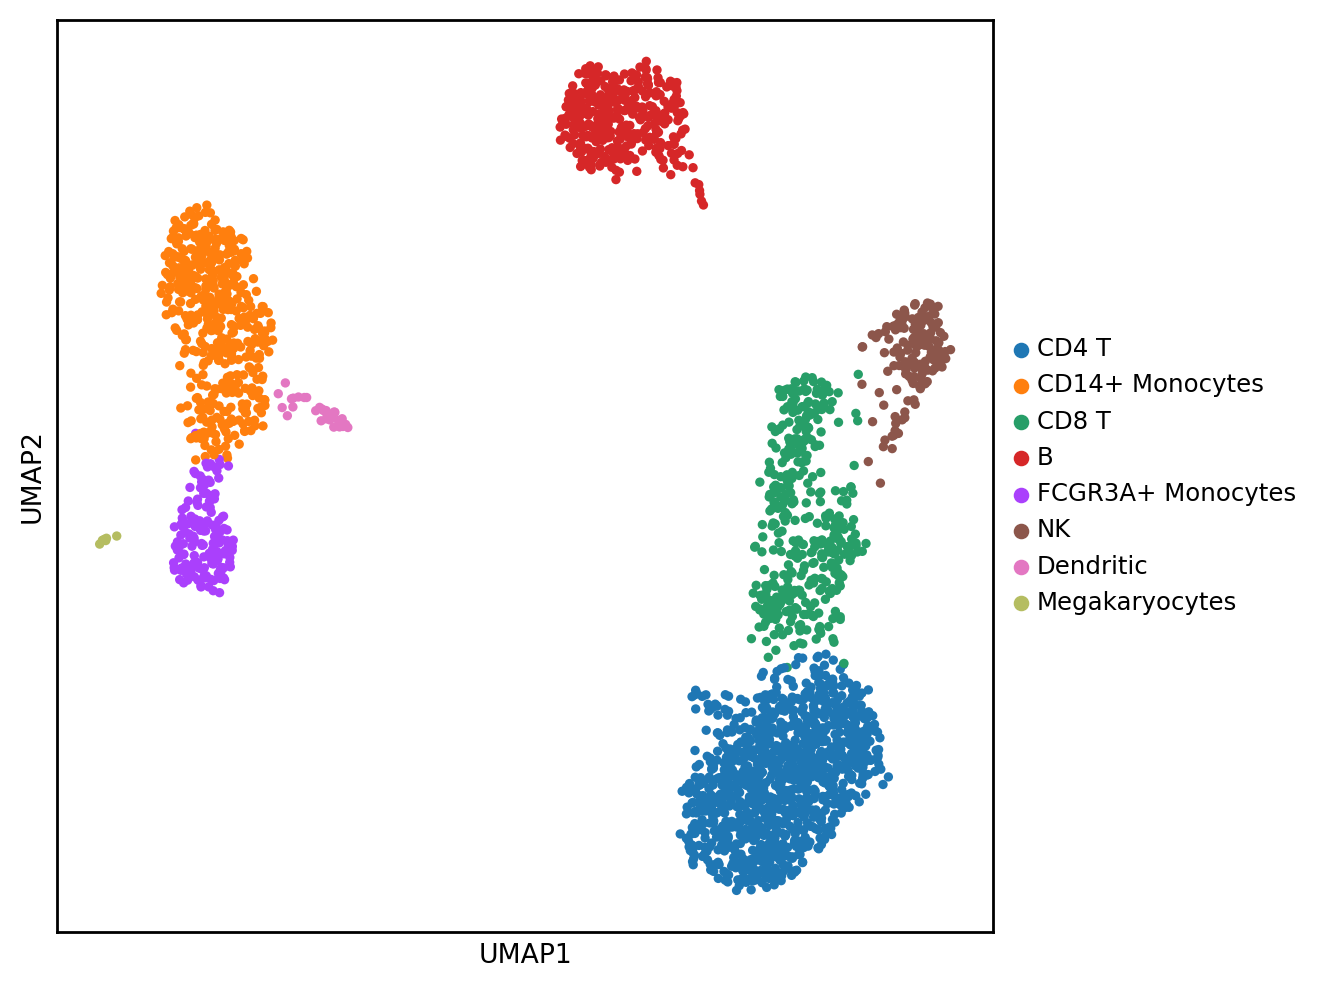

In [48]:
rcParams['figure.figsize']=(6,6)
sc.pl.umap(
    adata, color="leiden_r0.5", legend_loc="right margin", title="", frameon=True #frameon
#Draw a frame around the scatter plot. Defaults to value set in set_figure_params(), defaults to True
    , save=".pdf"
)

# Save data to file

In [49]:
adata.write('data_processed.h5ad')